# Libs

In [2]:
import warnings
warnings.filterwarnings('ignore')

import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg
from matplotlib.patches import Circle
import matplotlib.patches as patches
import seaborn as sns

from sklearn.metrics.pairwise import euclidean_distances
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler
from scipy.interpolate import interp1d

from tqdm.notebook import tqdm
import plotly.graph_objects as go
import plotly.io as pio

import geopandas as gpd
from shapely.geometry import Point

from pykrige.rk import Krige
from pykrige.rk import RegressionKriging
from pykrige.ok import OrdinaryKriging

pd.options.display.precision = 3
pd.options.display.float_format = lambda x: '%.5f' % x
pd.options.display.max_columns = 15
pd.options.display.max_rows = 6

# Data uploading

In [3]:
df_bal8_v4 = pd.read_csv('C:\jupyter\SPP\inputoutput\general_logs\df_bal8_azr_v4.csv')
df_bal8_v4.columns = df_bal8_v4.columns.str.lower()
df_bal8_v4.loc[df_bal8_v4.formation=='Balakhany VIII sand','formation'] = '1_bal8_sand'
df_bal8_v4.loc[df_bal8_v4.formation=='Balakhany VIII 25','formation'] = '2_bal8_25'
df_bal8_v4.loc[df_bal8_v4.formation=='Balakhany VIII 20','formation'] = '3_bal8_20'
df_bal8_v4.loc[df_bal8_v4.formation=='Balakhany VIII 15','formation'] = '4_bal8_15'
df_bal8_v4.loc[df_bal8_v4.formation=='Balakhany VIII 10','formation'] = '5_bal8_10'
df_bal8_v4.loc[df_bal8_v4.formation=='Balakhany VIII 5','formation'] = '6_bal8_5'
well_phit_flag8 = df_bal8_v4[df_bal8_v4.phit_flag==1].groupby('well')['phit_flag'].apply(lambda x: x.iloc[0]).reset_index().well.unique()
df_bal8_v4_flag = df_bal8_v4[df_bal8_v4.well.isin(well_phit_flag8)]
df_bal8_v4_flag = df_bal8_v4_flag[~df_bal8_v4_flag.well.isin(['B01ST1', 'D01', 'C14', 'C01A', 'B06', 'C13Z', 'C06', 'D01Z','C07'])]

df_bal10_v4 = pd.read_csv('C:\jupyter\SPP\inputoutput\general_logs\df_bal10_vshclp2_v4.csv')
df_bal10_v4.columns = df_bal10_v4.columns.str.lower()
df_bal10_v4.loc[df_bal10_v4.formation=='Balakhany X sand','formation'] = '1_bal10_sand'
df_bal10_v4.loc[df_bal10_v4.formation=='Balakhany X 50','formation'] = '2_bal10_40'
df_bal10_v4.loc[df_bal10_v4.formation=='Balakhany X 40','formation'] = '2_bal10_40'
df_bal10_v4.loc[df_bal10_v4.formation=='Balakhany X 20','formation'] = '3_bal10_20'
well_phit_flag10 = df_bal10_v4[df_bal10_v4.phit_flag==1].groupby('well')['phit_flag'].apply(lambda x: x.iloc[0]).reset_index().well.unique()
df_bal10_v4_flag = df_bal10_v4[df_bal10_v4.well.isin(well_phit_flag10)]

In [4]:
ntd_top_phi_bot8_bp_v4 = pd.read_csv(r'C:\jupyter\SPP\inputoutput\layers\ntd_top_phi_bot8_bp_v4.csv').drop('Unnamed: 0', axis=1)
ntd_top_phi_bot8_bp_v4.columns = ntd_top_phi_bot8_bp_v4.columns.str.lower()
ntd_top_phi_bot8_bp_v4 = ntd_top_phi_bot8_bp_v4[~ntd_top_phi_bot8_bp_v4.well.isin(['B01ST1', 'D01', 'C14', 'C01A', 'B06', 'C13Z', 'C06', 'D01Z','C07'])]

ntd_top_phi_bot10_bp_v4 = pd.read_csv(r'C:\jupyter\SPP\inputoutput\layers\ntd_top_phi_bot10_bp_v4.csv').drop('Unnamed: 0', axis=1)
ntd_top_phi_bot10_bp_v4.columns = ntd_top_phi_bot10_bp_v4.columns.str.lower()

In [5]:
def well_dist_calc(dataset, fm):
    data = dataset.groupby('well')[['xmean', 'ymean']].first().reset_index().dropna()
    row_name = data.well.reset_index().drop(['index'], axis=1)
    distance_fm = pd.DataFrame(euclidean_distances(data[['xmean', 'ymean']]), columns=list(data.well))
    distance_fm_well = distance_fm.join(row_name).set_index('well')
    distance_fm_well = distance_fm_well.reset_index()
    dist_melt = distance_fm_well.melt(id_vars='well', 
                                var_name='well2', 
                                value_name='dist').rename(columns={'well':'well_offset', 'well2':'well'})
    dist_melt = dist_melt[['well', 'well_offset', 'dist']]
    dist_melt = dist_melt[dist_melt.dist != 0].sort_values(by=['well','dist'])
    dist_melt['formation_up'] = fm
    return dist_melt

dist_bal8 = well_dist_calc(df_bal8_v4_flag, 'Balakhany VIII')
dist_bal10 = well_dist_calc(df_bal10_v4_flag, 'Balakhany X')

In [ ]:
k01 = pd.read_csv(r'C:\jupyter\SPP\input\ACG_k01.csv')[1:].drop('datasetName', axis=1)
k01 = k01.rename(columns={'wellName':'well'})
k01 = k01[k01.FORMATION.isin(['Balakhany VIII sand', 'Balakhany VIII 20','Balakhany VIII 15', 'Balakhany VIII 10', 'Balakhany VIII 5'])]
k01['FORMATION_up'] = 'Balakhany VIII'
k01['field'] = 'ACE'
for col in [    'MD', 'AREA', 'BADPORLOG', 'FLANK', 'Fluidcode',
                'FLUIDCODE_PP', 'GR_N', 'GRMATRIX', 'GRSHALE', 'LPERM',
                'LPERM_DS_Bal', 'LPERM_US_Bal', 'NET', 'NPSS', 'PHIT', 'RDEEP', 'RHOB',
                'RHOF', 'RHOMA', 'TST', 'TVD_SCS', 'X', 'Y']:
    k01[col] = pd.to_numeric(k01[col], errors='coerce')
k01 = k01[(k01.PHIT > 0)]
k01 = k01.round({'MD':1, 'TVD_SCS':1, 'TST':1, 'X':0, 'Y':0})
for col in ['well', 'FORMATION', 'FORMATION_up', 'field']:
    k01[col] = k01[col].astype('string')

def interpolate_by_depth_fm_run_k01(df, step):
    df_tst = df[df.TST.notna()].round({'MD':1})
    
    def interpolate_by_depth_fm_v2(one_well, step):
        one_well = one_well.sort_values(by='TST')
        well_name = one_well["well"].iloc[0]
        formation = one_well["FORMATION"].iloc[0]
        formation_up = one_well["FORMATION_up"].iloc[0]
        field = one_well["field"].iloc[0]
        data_range = np.floor((one_well["TST"].max() - one_well["TST"].min())/step)
        starting_tst = one_well["TST"].iloc[0]
        new_TST_values = [starting_tst + i*0.1 for i in range(1,int(data_range))]
        col_lst = []
        for col in one_well.columns:
            if col not in ['well','FORMATION_up', 'FORMATION','field']:
                interp = interp1d(one_well['TST'], one_well[col], kind='linear', fill_value="extrapolate")
                new_data = {col: interp(new_TST_values)}
                new_df = pd.DataFrame(new_data)
                col_lst.append(new_df)
        new_df = pd.concat(col_lst, axis=1)
        new_df['well'] = well_name
        new_df['TST'] = new_TST_values
        # new_df['FORMATION'] = formation
        # new_df['FORMATION_up'] = formation_up
        # new_df['field'] = field #Index(['FORMATION', 'FORMATION_up', 'field'], dtype='object')
        # new_df = new_df[[   'well', 
        #                     'TST', 'tst_index', 'MD',  'DEVI', 'HAZI', 'NET', 'NET_VSH', 'LPERM',
        #                     'PHIT', 'GR_N', 'VSH', 'NPSS', 'RHOB', 'RDEEP', 'SON', 'SONSH',
        #                     'TVD_SCS', 'X_traj', 'Y_traj', 'Xmean', 'Ymean', 'RHOF', 'RHOMA',
        #                     'tst_sample', 'NET_clp', 'NET_clp2', 'phit_flag', 'PERM_DS', 'PERM_US',
        #                     'k_htst', 'KHtst', 'VSH_smooth', 'NET_smooth', 'NET_orig',
        #                     'NET_VSH_orig', 'TST_interv', 'TST_interv_fu', 'fluid_code', 'calc',
        #                     'calc_net', 'phitd_npss']]
        return new_df
    df_lst = []
    for well in tqdm(df_tst.well.unique()):
        well_data = df_tst[df_tst.well == well]
        well_data_interp = interpolate_by_depth_fm_v2(well_data, 0.1)
        df_lst.append(well_data_interp)
    df_interp = pd.concat(df_lst)
    df_interp = df_interp.round({'MD':1, 'TVD_SCS':1, 'TST':1})
    print('Start joining')
    def well_bal_interp_join(dataset):
        df_tst = df[(df.TST.notna()) & (df.FORMATION_up.notna())].round({'MD':1})
        data_fu = df_tst[['well','MD','FORMATION_up', 'FORMATION', 'field']]
        well_join = dataset.set_index(['well','MD']).join(data_fu.set_index(['well','MD'])).reset_index()
        well_join.insert(3, 'FORMATION_up', well_join.pop('FORMATION_up'))
        well_join.insert(4, 'FORMATION', well_join.pop('FORMATION'))
        # well_join.insert(5, 'tst_index', well_join.pop('tst_index'))
        return well_join
    well_interp_v2 = well_bal_interp_join(df_interp)
    # well_interp_v2.loc[well_interp_v2.NET_VSH > 0, 'NET_VSH'] = 1
    # well_interp_v2.loc[well_interp_v2.NET > 0, 'NET'] = 1
    
    df_lst_2 = []
    for well in well_interp_v2.well.unique():
        field_data = well_interp_v2[well_interp_v2.well == well]
        field_data.field = field_data.field.fillna(method = 'ffill')
        field_data.field = field_data.field.fillna(method = 'bfill')
        field_data.FORMATION_up = field_data.FORMATION_up.fillna(method = 'ffill')
        field_data.FORMATION_up = field_data.FORMATION_up.fillna(method = 'bfill')
        field_data.FORMATION = field_data.FORMATION.fillna(method = 'ffill')
        field_data.FORMATION = field_data.FORMATION.fillna(method = 'bfill')
        df_lst_2.append(field_data)
    well_interp_v3 = pd.concat(df_lst_2)

    return well_interp_v3

k01_intepr = interpolate_by_depth_fm_run_k01(k01, 0.1)
k01_intepr.columns = k01_intepr.columns.str.lower()
k01_intepr['son'] = 0
k01_intepr['sonsh'] = 0
k01_intepr['xmean'] = k01_intepr.x.mean()
k01_intepr['ymean'] = k01_intepr.y.mean()
k01_gb = k01_intepr[k01_intepr.net==1].groupby('well')[['phit', 'xmean', 'ymean']].mean().reset_index()
k01_gb = k01_gb.rename(columns={'phit':'phit_w_avg'})

# Well pairs

In [7]:
# df_lst = []
# for wellname in dist_bal8.well.unique():
#     data = dist_bal8[dist_bal8.well == wellname].iloc[0:1]
#     df_lst.append(data)
# well_pairs = pd.concat(df_lst).reset_index(drop=True).drop_duplicates(subset=['dist'])
# well_pairs_v2 = well_pairs[well_pairs.dist < 500] # 235m is the max distance between wells selected by elbow plot with distance 500m
# # well_pairs.hist(column='dist', bins=50)
# well_pairs_v2.sort_values(by='dist', ascending=True)

In [8]:
# fig = plt.figure(figsize=(20, 5))
# sns.lineplot(data=well_pairs_v2.sort_values(by='dist', ascending=False), x='well', y='dist')
# plt.xticks(rotation=90)
# plt.grid()

In [9]:
# df_lst = []
# for wellname in dist_bal8.well.unique():
#     data = dist_bal8[dist_bal8.well == wellname].iloc[0:1]
#     df_lst.append(data)
# well_pairs = pd.concat(df_lst).reset_index(drop=True).drop_duplicates(subset=['dist'])
# well_pairs_v3 = well_pairs[well_pairs.dist < 230] # 235m is the max distance between wells selected by elbow plot with distance 500m
# # well_pairs.hist(column='dist', bins=50)
# well_pairs_v3 = well_pairs_v3.sort_values(by='dist', ascending=True).reset_index(drop=True)
# well_pairs_v3

In [10]:
# def well_offset_comparison_dashboard_pairs(dataset_wells, dataset_layers, dist_df,  well_target, offset_qty, fm_name, print_flag):
#     offset_well_list = dist_df[dist_df.well == well_target].iloc[:offset_qty]['well_offset'].values.tolist()
#     # offset_well_list = dist_df[dist_df.well == well_target].iloc[:offset_qty]
#     well_list = [well_target] + offset_well_list
#     data_logs = dataset_wells[(dataset_wells.well.isin(well_list)) & (dataset_wells.phit != 0)]
#     data_layers = dataset_layers[   (dataset_layers.well.isin(well_list)) & 
#                                     (dataset_layers.htst > 1)]
#     khtst_logs = data_logs.groupby(['well','formation'])[['khtst']].apply(lambda x: x.iloc[0] - x.iloc[-1]).reset_index()

#     def khtst_layer_calculation(data_logs):
#         data = data_logs[data_logs.net == 1]
#         df_lst = []
#         for wellname in data.well.unique():
#             well_data = data_logs[data_logs.well == wellname]
#             well_data['tst_index_rev'] = [i for i in range(len(well_data['tst']))[::-1]]
#             df_lst.append(well_data)
#         data_logs_khtst = pd.concat(df_lst)
#         return data_logs_khtst
#     data_logs_khtst = khtst_layer_calculation(data_logs)

#     def well_dist_title(dist_df):
#         offset_well_list = dist_df[dist_df.well == well_target].iloc[:offset_qty]
#         well = offset_well_list['well'].iloc[0]
#         well1 = offset_well_list.iloc[0,1]
#         dist1 = offset_well_list.iloc[0,2].round(0).astype(int)
#         # well2 = offset_well_list.iloc[1,1]
#         # dist2 = offset_well_list.iloc[1,2].round(0).astype(int)
#         # well3 = offset_well_list.iloc[2,1]
#         # dist3 = offset_well_list.iloc[2,2].round(0).astype(int)
#         return f"target well {well} : offsets {well1} - {dist1}m orange;"

#     fig = plt.figure(figsize=(22, 10))
#     gs = gridspec.GridSpec(2, 4, figure=fig)
#     ax1 = fig.add_subplot(gs[0, 0])
#     ax2 = fig.add_subplot(gs[0, 1])
#     ax3 = fig.add_subplot(gs[0, 2])
#     ax4 = fig.add_subplot(gs[0, 3])
#     ax5 = fig.add_subplot(gs[1, :3])

#     custom_palette = {well_target: 'red', offset_well_list[0]: 'orange'}
#     sns.histplot(data=data_logs, x='phit', hue='well', bins=50, kde=True, ax=ax1, palette=custom_palette)
#     sns.scatterplot(data=data_layers, x='htst', y='perm_avg', hue='well', s=75, ax=ax2, alpha=0.5, ec='black', palette=custom_palette)
#     sns.lineplot(data=data_logs_khtst, x='tst_index_rev', y='khtst', hue='well', ax=ax3, palette=custom_palette)
#     sns.barplot(data = khtst_logs, x='formation', y='khtst', hue='well', ax=ax4, palette=custom_palette)
#     ax1.set_yticklabels(ax1.get_yticklabels(), rotation=90, va='center')
#     ax2.set_yscale('log')
#     ax2.grid(True, which='both', linestyle='--', linewidth=0.5)
#     ax2.set_yticklabels(ax2.get_yticklabels(), rotation=90, va='center')
#     ax3.grid(True, which='both', linestyle='--', linewidth=0.5)
#     ax3.set_yticklabels(ax3.get_yticklabels(), rotation=90, va='center')

#     x = np.arange(len(khtst_logs.formation.unique()))
#     fms = khtst_logs.formation.unique()
#     ax4.set_xticks(x, fms, rotation=45, fontsize=6)
#     ax4.set_yticklabels(ax4.get_yticklabels(), rotation=90, va='center')

#     offset_well_list = dist_df[dist_df.well == well_target].iloc[:offset_qty]['well_offset'].values.tolist()
#     x = dataset_wells[dataset_wells.phit_flag == 1]['xmean']
#     y = dataset_wells[dataset_wells.phit_flag == 1]['ymean']
#     x_target = dataset_wells[dataset_wells.well == well_target]['xmean'].iloc[0]
#     y_target = dataset_wells[dataset_wells.well == well_target]['ymean'].iloc[0]
#     x_well1 = dataset_wells[dataset_wells.well == offset_well_list[0]]['xmean'].iloc[0]
#     y_well1 = dataset_wells[dataset_wells.well == offset_well_list[0]]['ymean'].iloc[0]
#     # x_well2 = dataset_wells[dataset_wells.well == offset_well_list[1]]['xmean'].iloc[0]
#     # y_well2 = dataset_wells[dataset_wells.well == offset_well_list[1]]['ymean'].iloc[0]
#     # x_well3 = dataset_wells[dataset_wells.well == offset_well_list[2]]['xmean'].iloc[0]
#     # y_well3 = dataset_wells[dataset_wells.well == offset_well_list[2]]['ymean'].iloc[0]
#     ax5.scatter(x, y, color='gray', s=10)
#     ax5.scatter(x_target, y_target, color='red', s=50, ec='black')
#     ax5.scatter(x_well1, y_well1, color='orange')
#     # ax5.scatter(x_well2, y_well2, color='green')
#     # ax5.scatter(x_well3, y_well3, color='#0797eb')

#     plt.suptitle(well_dist_title(dist_df), fontsize=16, y=0.92, x=0.32)
#     if print_flag == 'print':
#         plt.savefig(f'C:/jupyter/SPP/plots/offset_dashboard/{fm_name}_{well_target}_offset_dashboard.png');

# # df_bal8_v4_flag = df_bal8_v4_flag[~df_bal8_v4_flag.well.isin(['E31Z', 'D01Z'])]
# dist_bal8 = well_dist_calc(df_bal8_v4_flag, 'Balakhany VIII').round(0)
# for wellname in well_pairs_v3.well:
#     try:
#         well_offset_comparison_dashboard_pairs(df_bal8_v4_flag, ntd_top_phi_bot8_bp_v4, well_pairs_v3, wellname, 1, 'bal8','dontprint')
#     except:
#         print(f"error in {wellname}")

# Gas wells

In [11]:
ntd_top_phi_bot8_bp_v4['htst*phit_avg'] = ntd_top_phi_bot8_bp_v4['htst'] * ntd_top_phi_bot8_bp_v4['phit_avg']
ntd8 = ntd_top_phi_bot8_bp_v4.groupby('well')[['phit_avg','htst', 'htst*phit_avg']].agg({'phit_avg':'mean','htst':'sum', 'htst*phit_avg':'sum'}).reset_index()
xy = df_bal8_v4_flag.groupby('well')[['xmean','ymean']].first().reset_index()
ntd8 = ntd8.merge(xy, on='well').round({'xmean':0, 'ymean':0})
ntd8['phit_w_avg'] = ntd8['htst*phit_avg'] / ntd8['htst']
ntd8 = ntd8[['well', 'phit_avg', 'htst', 'phit_w_avg', 'xmean', 'ymean']]

field = df_bal8_v4.groupby('well')['field'].first().reset_index()
ntd8 = ntd8.merge(field, on='well')
ntd8 = ntd8[['well', 'phit_avg', 'htst', 'phit_w_avg', 'xmean', 'ymean', 'field']]
ntd8 = pd.get_dummies(ntd8, columns=['field'])

In [ ]:
gas_wells = df_bal8_v4_flag.groupby(['well', 'fluid_code'])['tst'].count().reset_index().rename(columns={'tst':'fluid_code_points'})
total = df_bal8_v4_flag.groupby('well')['tst'].count().reset_index().rename(columns={'tst':'total_points'})
gas_wells_v2 = gas_wells.set_index('well').join(total.set_index('well')).reset_index()
gas_wells_v2['fluid_code%'] = gas_wells_v2['fluid_code_points']/gas_wells_v2['total_points']
gas_wells_v2 = gas_wells_v2[(gas_wells_v2.fluid_code == 1) & (gas_wells_v2['fluid_code%'] > 0.5)]
names_gas_wells_v2 = gas_wells_v2.well.unique()
print('total gas wells: ', len(names_gas_wells_v2))

ntd8['gas_well'] = 0
ntd8.loc[ntd8.well.isin(names_gas_wells_v2), 'gas_well'] = 1

custom_palette = {1: 'red', 0: 'green'}
sns.scatterplot(data=ntd8, x='htst', y='phit_w_avg', hue='gas_well', s=50, alpha=0.5, ec='black', palette=custom_palette)
for idx, txt in enumerate(ntd8.well):
    plt.annotate(txt, (ntd8.htst.iloc[idx], ntd8.phit_w_avg.iloc[idx]), fontsize=6)
plt.title('phit_w_avg vs htst')
plt.grid()
plt.xlim(20, 80)
plt.ylim(0.15, 0.30);

# Anithotropy test 42

In [13]:
# from sklearn.base import BaseEstimator, RegressorMixin

# param_dict = {
#     "variogram_model": ["linear", "exponencial", "power", "gaussian", "spherical"],
#     'nlags': [l for l in range(5, 31, 1)],
#     "anisotropy_scaling": [s for s in np.arange(0.1, 1.1, 0.1)],
#     "anisotropy_angle": [a for a in range(0, 180, 10)],
# }

# feature_bal8 = ntd8[['htst','field_CENTRAL AZERI', 'field_EAST AZERI', 'field_WEST AZERI']].values.reshape(-1,4)
# coord_bal8 = ntd8[['xmean', 'ymean']].values
# target_bal8 = ntd8['phit_w_avg'].values

# f_train, f_test, xy_train, xy_test, target_train, target_test = train_test_split(
#     feature_bal8, coord_bal8, target_bal8, test_size=0.3, random_state=42)

# class KrigingRegressor(BaseEstimator, RegressorMixin):
#     def __init__(self, variogram_model='linear', nlags=6, anisotropy_scaling=1, anisotropy_angle=0):
#         self.variogram_model = variogram_model
#         self.nlags = nlags
#         self.anisotropy_scaling = anisotropy_scaling
#         self.anisotropy_angle = anisotropy_angle

#     def fit(self, X, y):
#         self.ok_ = OrdinaryKriging(
#                                         X[:, 0], X[:, 1], y,
#                                         variogram_model=self.variogram_model,
#                                         nlags=self.nlags,
#                                         anisotropy_scaling=self.anisotropy_scaling,
#                                         anisotropy_angle=self.anisotropy_angle
#                                     )
#         return self

#     def predict(self, X):
#         z, ss = self.ok_.execute('points', X[:, 0], X[:, 1])
#         return z


# grid_search = GridSearchCV(KrigingRegressor(), param_dict, cv=5)
# grid_search.fit(coord_bal8, target_bal8)

# if hasattr(grid_search, "best_score_"):
#     print("best_score R² = {:.3f}".format(grid_search.best_score_))
#     print("best_params = ", grid_search.best_params_)

In [14]:
# best_score R² = -0.266
# best_params =  {'anisotropy_angle': 70, 'anisotropy_scaling': 0.6, 'nlags': 8, 'variogram_model': 'gaussian'}

# Testing influence ml, kriging, ml+kriging to prediction

## Target based on nn-average

In [15]:
def add_phit_dist_df(df_ntd, df_dist):
    df_lst = []
    for well_offset in df_dist.well_offset.unique():
        phit = df_ntd[df_ntd.well == well_offset][['well','htst','phit_avg']]
        phit['htst*phit'] = phit['htst']*phit['phit_avg']
        phit_htst = phit['htst*phit'].sum()
        htst_sum = phit['htst'].sum()
        phit_wavg = phit_htst/htst_sum
        df_lst.append((well_offset, phit_wavg, htst_sum))
    phit_dist = pd.DataFrame(df_lst, columns=['well', 'phit_wavg', 'htst_sum'])
    dist_v2 = (df_dist.merge(phit_dist, left_on='well_offset', right_on='well', how='left')).merge(
        phit_dist, left_on='well_x', right_on='well', how='left')
    dist_v2 = dist_v2[['well_x','phit_wavg_y', 'well_offset', 'htst_sum_y','dist','phit_wavg_x','htst_sum_x','formation_up']].rename(
                    columns={'well_x':'well', 'phit_wavg_y':'phit_target', 'htst_sum_y':'htst_target', 
                             'phit_wavg_x':'phit_offset', 'htst_sum_x':'htst_offset', 'dist':'dist_offset'})
    return dist_v2

def add_htst_bins(df_ntd):
    qunatiles_df = pd.DataFrame(df_ntd[df_ntd.htst > 2].htst.quantile([0.25,0.5,0.75]), 
                            columns=['htst']).reset_index().rename(columns={'index':'qunatiles'})
    qunatiles_df['htst'] = qunatiles_df['htst'].round(0)
    bins = [0, qunatiles_df.htst.iloc[0], qunatiles_df.htst.iloc[1], qunatiles_df.htst.iloc[2], 100]
    labesl = ['htst_<3m', 'htst_3-4m', 'htst_4_7m', 'htst_>7m']
    df_ntd['htst_bins'] = pd.cut(df_ntd.htst, bins=bins, labels=labesl)

    df_lst = []
    for wellname in df_ntd.well.unique():
        htst_bins = df_ntd[df_ntd.well == wellname].groupby('htst_bins')['htst'].count().reset_index()
        htst_bins_v2 = htst_bins.T
        htst_bins_v2.columns = htst_bins_v2.iloc[0]
        htst_bins_v2 = htst_bins_v2.drop('htst_bins')
        htst_bins_v2['well'] = wellname
        df_lst.append(htst_bins_v2)
    htst_bins_df = pd.concat(df_lst).reset_index(drop=True)
    return htst_bins_df

def selection_quantity_well(df_dist_v2, q):
    df_lst = []
    for wellname in df_dist_v2.well.unique():
        well_set = df_dist_v2[df_dist_v2.well == wellname].iloc[:q]
        df_lst.append(well_set)
    dist_v3 = pd.concat(df_lst).reset_index(drop=True)
    return dist_v3

def assesment_phit_by_offset_avg(df_dist_v3, quality_range):
    df_lst = []
    for wellname in df_dist_v3.well.unique():
        data = df_dist_v3[df_dist_v3.well == wellname]
        weighted_average = np.average(data.phit_offset.values, weights=data.dist_offset.values)
        data['weighted_average'] = weighted_average
        df_lst.append(data)
    dist_v4 = pd.concat(df_lst).reset_index(drop=True)
    dist_v4['phit_target_high'] = dist_v4.phit_target + quality_range
    dist_v4['phit_target_low'] = dist_v4.phit_target - quality_range
    dist_v4['phit_pred_qc'] = 'in_range' # 0 - below low, 1 - within range, 2 - above high
    # dist_v4['phit_target_high'] = dist_v4.phit_target*(1 + quality_range)
    # dist_v4['phit_target_low'] = dist_v4.phit_target*(1 - quality_range)
    # dist_v4['phit_pred_qc'] = 'in_range' # 0 - below low, 1 - within range, 2 - above high
    dist_v4.loc[dist_v4.weighted_average <= dist_v4.phit_target_low, 'phit_pred_qc'] = 'under_estimated'
    dist_v4.loc[dist_v4.weighted_average >= dist_v4.phit_target_high, 'phit_pred_qc'] = 'over_estimated'
    dist_v4 = dist_v4[[ 'well', 'phit_target', 'well_offset', 'dist_offset', 'phit_offset', 'formation_up',
                        'phit_target_high', 'weighted_average','phit_target_low', 'phit_pred_qc']]
    result = pd.DataFrame(dist_v4[['well','phit_pred_qc']].drop_duplicates().value_counts('phit_pred_qc', normalize=True)).reset_index()
    result = result.sort_values(by='phit_pred_qc', ascending=True).reset_index(drop=True)
    return dist_v4, result

def assesment_htst_by_offset_avg(df_dist_v3, quality_range):
    df_lst = []
    for wellname in df_dist_v3.well.unique():
        data = df_dist_v3[df_dist_v3.well == wellname]
        weighted_average = np.average(data.htst_offset.values, weights=data.dist_offset.values)
        data['weighted_average'] = weighted_average
        df_lst.append(data)
    dist_v4 = pd.concat(df_lst).reset_index(drop=True)
    dist_v4['htst_target_high'] = dist_v4.htst_target + quality_range
    dist_v4['htst_target_low'] = dist_v4.htst_target - quality_range
    dist_v4['htst_pred_qc'] = 'in_range' # 0 - below low, 1 - within range, 2 - above high
    # dist_v4['htst_target_high'] = dist_v4.htst_target*(1 + quality_range)
    # dist_v4['htst_target_low'] = dist_v4.htst_target*(1 - quality_range)
    # dist_v4['htst_pred_qc'] = 'in_range' # 0 - below low, 1 - within range, 2 - above high
    dist_v4.loc[dist_v4.weighted_average <= dist_v4.htst_target_low, 'htst_pred_qc'] = 'under_estimated'
    dist_v4.loc[dist_v4.weighted_average >= dist_v4.htst_target_high, 'htst_pred_qc'] = 'over_estimated'
    dist_v4 = dist_v4[[ 'well', 'htst_target', 'well_offset', 'dist_offset', 'htst_offset', 'formation_up',
                        'htst_target_high', 'weighted_average','htst_target_low', 'htst_pred_qc']]
    result = pd.DataFrame(dist_v4[['well','htst_pred_qc']].drop_duplicates().value_counts('htst_pred_qc', normalize=True)).reset_index()
    result = result.sort_values(by='htst_pred_qc', ascending=True).reset_index(drop=True)
    return dist_v4, result

def well_dist_calc(dataset, fm):
    data = dataset.groupby('well')[['xmean', 'ymean']].first().reset_index().dropna()
    row_name = data.well.reset_index().drop(['index'], axis=1)
    distance_fm = pd.DataFrame(euclidean_distances(data[['xmean', 'ymean']]), columns=list(data.well))
    distance_fm_well = distance_fm.join(row_name).set_index('well')
    distance_fm_well = distance_fm_well.reset_index()
    dist_melt = distance_fm_well.melt(id_vars='well', 
                                var_name='well2', 
                                value_name='dist').rename(columns={'well':'well_offset', 'well2':'well'})
    dist_melt = dist_melt[['well', 'well_offset', 'dist']]
    dist_melt = dist_melt[dist_melt.dist != 0].sort_values(by=['well','dist'])
    dist_melt['formation_up'] = fm
    return dist_melt

In [ ]:
dist_bal8 = well_dist_calc(df_bal8_v4_flag, 'Balakhany VIII')
dist_bal10 = well_dist_calc(df_bal10_v4_flag, 'Balakhany X')

df_range_phit_lst = []
df_range_htst_lst = []
for q in range(1,16):
    dist_bal8_v2 = add_phit_dist_df(ntd_top_phi_bot8_bp_v4, dist_bal8)
    dist_bal8_v3 = selection_quantity_well(dist_bal8_v2, q)
    dist_bal8_v4_phit, result_bal8_phit = assesment_phit_by_offset_avg(dist_bal8_v3, 0.0115)
    dist_bal8_v4_htst, result_bal8_htst = assesment_htst_by_offset_avg(dist_bal8_v3, 4.25)
    result_bal8_phit['offset_qty'] = q
    result_bal8_htst['offset_qty'] = q
    df_range_phit_lst.append(result_bal8_phit)
    df_range_htst_lst.append(result_bal8_htst)

df_range_phit = pd.concat(df_range_phit_lst).reset_index(drop=True)
df_range_htst = pd.concat(df_range_htst_lst).reset_index(drop=True)
qc_phit_avg = df_range_phit[df_range_phit.phit_pred_qc == 'in_range'].sort_values(by='proportion', ascending=False).iloc[0:1,1].values[0].round(3)

fig, ax = plt.subplots(1,2, figsize=(14,4))
sns.lineplot(data=df_range_phit, x='offset_qty', y='proportion', hue='phit_pred_qc', ax=ax[0])
ax[0].grid()
ax[0].set_title('Prediction by weighted avg offset 0.0115')
sns.lineplot(data=df_range_htst, x='offset_qty', y='proportion', hue='htst_pred_qc', ax=ax[1])
ax[1].grid()
ax[1].set_title('Prediction by weighted avg offset 4.25')

## Calc nn-avg

In [ ]:
dist_bal8_v4_phit

In [ ]:
# ntd_top_phi_bot8_bp_v4 = ntd_top_phi_bot8_bp_v4[~ntd_top_phi_bot8_bp_v4.well.isin(['B14Z','B19','B13ST2'])]
# dist_bal8 = well_dist_calc(df_bal8_v4_flag[~df_bal8_v4_flag.well.isin(['B14Z','B19','B13ST2'])], 'Balakhany VIII')

q1, q2 = 2, 8
dist_bal8_v2 = add_phit_dist_df(ntd_top_phi_bot8_bp_v4, dist_bal8)
dist_bal8_v3_phit = selection_quantity_well(dist_bal8_v2, q1)
dist_bal8_v3_htst = selection_quantity_well(dist_bal8_v2, q2)
dist_bal8_v4_phit, result_bal8_phit = assesment_phit_by_offset_avg(dist_bal8_v3_phit, 0.0115)
dist_bal8_v4_htst, result_bal8_htst = assesment_htst_by_offset_avg(dist_bal8_v3_htst, 4.25)
result_bal8_phit['offset_qty'] = q1
result_bal8_htst['offset_qty'] = q2
dist_bal8_v4_phit['qc'] = np.where((dist_bal8_v4_phit.phit_pred_qc == 'in_range'), 1, 0)
dist_bal8_v4_htst['qc'] = np.where((dist_bal8_v4_htst.htst_pred_qc == 'in_range'), 1, 0)
dist_bal8_v4_phit = dist_bal8_v4_phit[[ 'well', 'phit_target', 'formation_up', 'phit_target_high', 'weighted_average',
                                        'phit_target_low', 'phit_pred_qc', 'qc']].drop_duplicates().reset_index(drop=True)
dist_bal8_v4_htst = dist_bal8_v4_htst[[ 'well', 'htst_target', 'formation_up', 'htst_target_high', 'weighted_average',
                                        'htst_target_low', 'htst_pred_qc', 'qc']].drop_duplicates().reset_index(drop=True)

feature_bal8_phit = dist_bal8_v4_phit[[ 'well', 'phit_target', 'formation_up', 
                                        'phit_target_high', 'weighted_average','phit_target_low', 
                                        'phit_pred_qc', 'qc']]
target_bal8_phit = dist_bal8_v4_phit['phit_target'].values

feature_bal8_htst = dist_bal8_v4_htst[[ 'well', 'htst_target', 'formation_up', 
                                        'htst_target_high', 'weighted_average', 'htst_target_low', 
                                        'htst_pred_qc', 'qc']]
target_bal8_htst = dist_bal8_v4_htst['htst_target'].values

def train_test_split_custom(feature, target, size, state):
    f_train, f_test, target_train, target_test = train_test_split(feature, target, test_size=size, random_state=state)
    return f_train, f_test, target_train, target_test

f_train_phit, f_test_phit, target_train_phit, target_test_phit = train_test_split_custom(feature_bal8_phit, target_bal8_phit, 0.5, 42)
f_train_htst, f_test_htst, target_train_htst, target_test_htst = train_test_split_custom(feature_bal8_htst, target_bal8_htst, 0.5, 42)

fig, ax = plt.subplots(1,2, figsize=(15,5))
custom_palette = {0: 'red', 1: 'green'}
qc_calc_nn_avg_phit = f_test_phit.qc.value_counts(normalize=True).reset_index()
sns.scatterplot(data=f_test_phit, x='phit_target', y='weighted_average', s=30, hue='qc', alpha=0.5, ec='black', palette=custom_palette, ax=ax[0])
sns.lineplot(x=[0.16,0.27], y=[0.16,0.27], color='blue', ls='--', ax = ax[0])
ax[0].set_title(f'nn_points {q1} nn_avg_phit qc = 1 ' + str(qc_calc_nn_avg_phit[qc_calc_nn_avg_phit.qc==1]['proportion'].values[0].round(2)))
ax[0].grid()
for idx, txt in enumerate(f_test_phit.well):
    ax[0].annotate(txt, (f_test_phit.phit_target.iloc[idx], f_test_phit.weighted_average.iloc[idx]), fontsize=6)

qc_calc_nn_avg_htst = f_test_htst.qc.value_counts(normalize=True).reset_index()
sns.scatterplot(data=f_test_htst, x='htst_target', y='weighted_average', s=30, hue='qc', alpha=0.5, ec='black', palette=custom_palette, ax=ax[1])
sns.lineplot(x=[30,80], y=[30,80], color='blue', ls='--', ax = ax[1])
ax[1].set_title(f'nn_points {q2} nn_avg_htst qc = 1 ' + str(qc_calc_nn_avg_htst[qc_calc_nn_avg_htst.qc==1]['proportion'].values[0].round(2)))
ax[1].grid()
for idx, txt in enumerate(f_test_htst.well):
    ax[1].annotate(txt, (f_test_htst.htst_target.iloc[idx], f_test_htst.weighted_average.iloc[idx]), fontsize=6);

## Feature creation

In [19]:
dist_bal8_v2_phit = add_phit_dist_df(ntd_top_phi_bot8_bp_v4, dist_bal8)
dist_bal8_v2_htstbins = add_htst_bins(ntd_top_phi_bot8_bp_v4)
dist_bal8_v2 = dist_bal8_v2_phit.set_index('well_offset').join(dist_bal8_v2_htstbins.set_index('well')).reset_index()
dist_bal8_v2 = dist_bal8_v2[[   'well', 'phit_target', 'htst_target', 'well_offset', 'dist_offset',
                                'phit_offset', 'htst_offset', 'htst_<3m', 'htst_3-4m',
                                'htst_4_7m', 'htst_>7m', 'formation_up']].sort_values(by=['well','dist_offset'])
dist_bal8_v3 = selection_quantity_well(dist_bal8_v2, 2)

In [ ]:
df_lst = []
for wellname in dist_bal8_v3.well.unique():
    df1 = dist_bal8_v3[dist_bal8_v3.well == wellname][[ 'well', 'well_offset', 'dist_offset', 'phit_offset', 'htst_offset',
                                                       'htst_<3m', 'htst_3-4m', 'htst_4_7m', 'htst_>7m']].iloc[0:1].reset_index(drop=True)
    df1.columns = df1.columns + '_w1'
    df2 = dist_bal8_v3[dist_bal8_v3.well == wellname][[ 'well', 'well_offset', 'dist_offset', 'phit_offset', 'htst_offset',
                                                       'htst_<3m', 'htst_3-4m', 'htst_4_7m', 'htst_>7m']].iloc[1:2].reset_index(drop=True)
    df2.columns = df2.columns + '_w2'
    df_target = dist_bal8_v3[dist_bal8_v3.well == wellname][[ 'well', 'phit_target', 'htst_target']].iloc[0:1].reset_index(drop=True).drop('well', axis=1)
    df = pd.concat([df1, df2], axis=1).drop('well_w2', axis=1).rename(columns={'well_w1':'well'})
    df_v2 = pd.concat([df, df_target], axis=1)
    # df_v2 = df_v2[[ 'well', 'phit_target', 'htst_target', 'well_offset_1', 'dist_offset_1', 'phit_offset_1',
    #                 'htst_offset_1', 'well_offset_2', 'dist_offset_2', 'phit_offset_2',
    #                 'htst_offset_2']]
    df_lst.append(df_v2)
dist_bal8_v4 = pd.concat(df_lst).reset_index(drop=True)
dist_bal8_v4.columns

In [21]:
feature_list1 =  [
                    'dist_offset_w1', 'phit_offset_w1', 'htst_offset_w1', 
                    'htst_<3m_w1', 'htst_3-4m_w1', 'htst_4_7m_w1', 'htst_>7m_w1', 
                    'dist_offset_w2', 'phit_offset_w2', 'htst_offset_w2', 
                    'htst_<3m_w2', 'htst_3-4m_w2', 'htst_4_7m_w2', 'htst_>7m_w2', 
                    'phit_target']
feature_list2 =  [
                  'dist_offset_w1', 'phit_offset_w1', 'htst_offset_w1', 
                    'htst_<3m_w1', 'htst_3-4m_w1', 'htst_4_7m_w1', 'htst_>7m_w1', 
                    'dist_offset_w2', 'phit_offset_w2', 'htst_offset_w2', 
                    'htst_<3m_w2', 'htst_3-4m_w2', 'htst_4_7m_w2', 'htst_>7m_w2', 
                    'phit_target']

In [ ]:
sns.pairplot(data=dist_bal8_v4[feature_list2], diag_kind='kde', plot_kws={'alpha':0.5})

In [23]:
# 1. написать функцию для расчета предикшена с разными ramdom_state для базовых настроек кригинга и модели              +
# 2. посчитать стабильность предсказаний для 100 разных random_state                                                    +
# 3. посчитать предсказание отдельно для регрессии, регрессии с кригингом и кригинга - везде базовые настройки          +
# 4. добавить расчет поросити по соседним скважинам                                                                     +

# Phit prediction

## Data preparation

In [24]:
# Several statistical metrics are commonly used to describe the distribution of a dataset. 
# These metrics provide insights into the shape, central tendency, and spread of the data. Here are some of the key metrics:

# Mean: The average of all data points. It provides a measure of central tendency.

# Median: The middle value when the data points are arranged in order. It is another measure of central tendency that 
# is less affected by outliers than the mean.

# Mode: The most frequently occurring value(s) in the dataset. It can be used to understand the most common or 
# popular values in a distribution.

# Standard Deviation (SD): Measures the amount of variation or dispersion of a set of values. A low SD indicates that 
# the values tend to be close to the mean, while a high SD indicates that the values are spread out over a wider range.

# Variance: The square of the standard deviation. It measures how far each number in the set is from the mean and thus 
# from every other number in the set.

# Range: The difference between the highest and lowest values in the dataset. It gives a sense of the spread of the data.

# Interquartile Range (IQR): The difference between the 75th percentile (Q3) and the 25th percentile (Q1) in the data. 
# It is a measure of statistical dispersion and is less affected by outliers.

# Skewness: A measure of the asymmetry of the probability distribution of a real-valued random variable. Positive skew indicates 
# a distribution with an asymmetric tail extending towards more positive values, while negative skew indicates a tail extending 
# towards more negative values.

# Kurtosis: A measure of the "tailedness" of the probability distribution. High kurtosis means a distribution has heavy tails 
# and a sharp peak, while low kurtosis means a distribution has light tails and a flat peak.

# Percentiles/Quartiles: Points in the distribution below which a certain percentage of the data falls. Quartiles are specific 
# percentiles: the 25th percentile (Q1), the 50th percentile (median or Q2), and the 75th percentile (Q3).

In [25]:
ntd_top_phi_bot8_bp_v4['htst*phit_avg'] = ntd_top_phi_bot8_bp_v4['htst'] * ntd_top_phi_bot8_bp_v4['phit_avg']
ntd8 = ntd_top_phi_bot8_bp_v4.groupby('well')[['phit_avg','htst', 'htst*phit_avg']].agg({'phit_avg':'mean','htst':'sum', 'htst*phit_avg':'sum'}).reset_index()
xy = df_bal8_v4_flag.groupby('well')[['xmean','ymean']].first().reset_index()
ntd8 = ntd8.merge(xy, on='well').round({'xmean':0, 'ymean':0})
ntd8['phit_w_avg'] = ntd8['htst*phit_avg'] / ntd8['htst']
ntd8 = ntd8[['well', 'phit_avg', 'htst', 'phit_w_avg', 'xmean', 'ymean']]

field = df_bal8_v4.groupby('well')['field'].first().reset_index()
ntd8 = ntd8.merge(field, on='well')
ntd8 = ntd8[['well', 'phit_avg', 'htst', 'phit_w_avg', 'xmean', 'ymean', 'field']]
ntd8 = pd.get_dummies(ntd8, columns=['field'])

## No features

In [26]:
# ntd8 = ntd8[~ntd8.well.isin(['B14Z','B19','B13ST2'])]

### One-to-all ml-kriging

In [27]:
# df_lst = []
# for idx in range(len(ntd8)):
#     feature_bal8_all = np.delete(ntd8[['htst']].values.reshape(-1,1), idx, axis=0)
#     coord_bal8_all = np.delete(ntd8[['xmean', 'ymean']].values, idx, axis=0)
#     target_bal8_all = np.delete(ntd8['phit_w_avg'].values, idx, axis=0)

#     feature_bal8_one = ntd8[['htst']].values[idx].reshape(-1,1)
#     coord_bal8_one = ntd8[['xmean', 'ymean']].values[idx].reshape(-1,2)
#     target_bal8_one = ntd8['phit_w_avg'].values[idx]

#     m_rk = RegressionKriging(regression_model=SVR(), n_closest_points=4, verbose=False)
#     m_rk.fit(feature_bal8_all, coord_bal8_all, target_bal8_all)
#     pred_rk_loo = m_rk.predict(feature_bal8_one, coord_bal8_one)
#     pred_rk_loo_df = pd.DataFrame({ 'model': SVR().__class__.__name__,
#                                     'nn_points': 4,
#                                     'well': ntd8.well[idx],
#                                     'phit_w_avg_pred':pred_rk_loo, 
#                                     'phit_w_avg_true':target_bal8_one}, index=[0])
#     df_lst.append(pred_rk_loo_df)
# df_1 = pd.concat(df_lst).reset_index(drop=True)
# df_1

In [28]:
# svr_model = SVR()
# rf_model = RandomForestRegressor()
# lr_model = LinearRegression()
# model_list = [svr_model, rf_model, lr_model]

# model_lst = []
# for model in tqdm(model_list):  
#     nn_lst = []
#     for nn_points in range(2,31,1):
#         df_lst = []
#         for idx in range(len(ntd8)):
#             feature_bal8_all = np.delete(ntd8[['htst']].values.reshape(-1,1), idx, axis=0)
#             coord_bal8_all = np.delete(ntd8[['xmean', 'ymean']].values, idx, axis=0)
#             target_bal8_all = np.delete(ntd8['phit_w_avg'].values, idx, axis=0)

#             feature_bal8_one = ntd8[['htst']].values[idx].reshape(-1,1)
#             coord_bal8_one = ntd8[['xmean', 'ymean']].values[idx].reshape(-1,2)
#             target_bal8_one = ntd8['phit_w_avg'].values[idx]

#             m_rk = RegressionKriging(regression_model=rf_model, n_closest_points=nn_points, verbose=False)
#             m_rk.fit(feature_bal8_all, coord_bal8_all, target_bal8_all)
#             pred_rk_loo = m_rk.predict(feature_bal8_one, coord_bal8_one)
#             pred_rk_loo_df = pd.DataFrame({ 'model': model.__class__.__name__,
#                                             'nn_points': nn_points,
#                                             'well': ntd8['well'].values[idx],
#                                             'phit_w_avg_pred':pred_rk_loo, 
#                                             'phit_w_avg_true':target_bal8_one}, index=[0])
#             df_lst.append(pred_rk_loo_df)
#         df_1 = pd.concat(df_lst).reset_index(drop=True)
#         nn_lst.append(df_1)
#     df_2 = pd.concat(nn_lst).reset_index(drop=True)
#     model_lst.append(df_2)
# result = pd.concat(model_lst).reset_index(drop=True)

# result['up_1.15pu'] = result.phit_w_avg_true+0.0115
# result['down_1.15pu'] = result.phit_w_avg_true-0.0115
# result['qc'] = np.where((result.phit_w_avg_pred >= result['down_1.15pu']) 
#                                 & (result.phit_w_avg_pred <= result['up_1.15pu']), 1, 0)
# result.to_csv('output/result8_pred_ml_kr_loo.csv', index=False)

In [ ]:
result = pd.read_csv('output/result8_pred_ml_kr_loo.csv')

df_lst = []
for model in result.model.unique():
    for nn in result.nn_points.unique():
        data = result[(result.model == model) & (result.nn_points == nn)].value_counts('qc', normalize=True)
        df = pd.DataFrame({'model': model, 'nn_points': nn, 'qc_1': data[1], 'qc_0': data[0]}, index=[0])
        df_lst.append(df)
result_v2 = pd.concat(df_lst).reset_index(drop=True)

def display_results_loo(result_v2):
    fig, ax = plt.subplots(1,3, figsize=(18,5))
    ax[0].step(result_v2[result_v2.model=='SVR']['nn_points'], 
            result_v2[result_v2.model=='SVR']['qc_1'], where='mid', label='SVR', color='blue')
    ax[1].step(result_v2[result_v2.model=='RandomForestRegressor']['nn_points'],
                result_v2[result_v2.model=='RandomForestRegressor']['qc_1'], where='mid', label='RRF', color='red')
    ax[2].step(result_v2[result_v2.model=='LinearRegression']['nn_points'],
                result_v2[result_v2.model=='LinearRegression']['qc_1'], where='mid', label='LR', color='green')
    ax[0].grid()
    ax[0].set_title('SVR')
    ax[0].set_ylim(0.45,0.55)
    ax[1].grid()
    ax[1].set_title('RandomForestRegressor')
    ax[1].set_ylim(0.45,0.55)
    ax[2].grid()
    ax[2].set_title('LinearRegression')
    ax[2].set_ylim(0.45,0.55)
display_results_loo(result_v2)

In [ ]:
svr_13 = result[(result.model == 'SVR') & (result.nn_points == 13)].sort_values(by='phit_w_avg_true', ascending=True)
svr_5 = result[(result.model == 'SVR') & (result.nn_points == 5)].sort_values(by='phit_w_avg_true', ascending=True)
display(svr_13)
fig, ax = plt.subplots(2,1,figsize=(18,10))
sns.lineplot(data=svr_13, x='well', y='phit_w_avg_true', ax=ax[0], label = 'true')
sns.lineplot(data=svr_13, x='well', y='phit_w_avg_pred', ax=ax[0], label = 'svr_13')
ax[0].fill_between(svr_13['well'], 
                    svr_13['phit_w_avg_true'] - 0.0115, svr_13['phit_w_avg_true'] + 0.0115, color='b', alpha=0.2) 
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45, fontsize=6)
ax[0].legend()
sns.lineplot(data=svr_5, x='well', y='phit_w_avg_true', ax=ax[1], label = 'true')
sns.lineplot(data=svr_5, x='well', y='phit_w_avg_pred', ax=ax[1], label = 'svr_5')
ax[1].fill_between( svr_5['well'], 
                    svr_5['phit_w_avg_true'] - 0.0115, svr_5['phit_w_avg_true'] + 0.0115, color='b', alpha=0.2) 
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45, fontsize=6);
ax[1].legend()

### One-to-all kriging

In [ ]:
# best_params =  {'anisotropy_angle': 70, 'anisotropy_scaling': 0.6, 'nlags': 8, 'variogram_model': 'gaussian'}
coord_bal8_all = np.delete(ntd8[['xmean', 'ymean']].values, idx, axis=0)
target_bal8_all = np.delete(ntd8['phit_w_avg'].values, idx, axis=0)

coord_bal8_one = ntd8[['well','xmean', 'ymean']].values[idx].reshape(-1,3)
target_bal8_one = ntd8['phit_w_avg'].values[idx]

kriging_loo = OrdinaryKriging(  coord_bal8_all[:,0], 
                                coord_bal8_all[:,1], 
                                target_bal8_all,
                                enable_plotting=1, 
                                variogram_model='gaussian',
                                nlags = 8,
                                weight=0, 
                                coordinates_type='euclidean', 
                                verbose=0, 
                                anisotropy_scaling=0.6,
                                anisotropy_angle=70)
pred_kriging_loo, ss = kriging_loo.execute('points', coord_bal8_one[:,1][0], coord_bal8_one[:,2][0])
pred_rk_loo_df = pd.DataFrame({ 'model': kriging_loo.__class__.__name__,
                                'nn_points': 2,
                                'well': ntd8.well[idx],
                                'phit_w_avg_pred':pred_kriging_loo,
                                'sigmasq': ss, 
                                'phit_w_avg_true':target_bal8_one}, index=[0])

pred_rk_loo_df

In [ ]:
def define_best_variogram():
    var_list = []
    for variogram in tqdm(['linear', 'power', 'gaussian', 'spherical', 'exponential']):
        df_lst = []
        for idx in range(len(ntd8)):
            coord_bal8_all = np.delete(ntd8[['xmean', 'ymean']].values, idx, axis=0)
            target_bal8_all = np.delete(ntd8['phit_w_avg'].values, idx, axis=0)

            coord_bal8_one = ntd8[['well','xmean', 'ymean']].values[idx].reshape(-1,3)
            target_bal8_one = ntd8['phit_w_avg'].values[idx]

            kriging_loo = OrdinaryKriging(  coord_bal8_all[:,0], 
                                            coord_bal8_all[:,1], 
                                            target_bal8_all, 
                                            variogram_model=variogram,
                                            nlags = 30,
                                            weight=0,  
                                            coordinates_type='euclidean', 
                                            verbose=0, 
                                            enable_plotting=0)
            pred_kriging_loo, ss = kriging_loo.execute('points', coord_bal8_one[:,1][0], coord_bal8_one[:,2][0])
            pred_rk_loo_df = pd.DataFrame({ 'model': kriging_loo.__class__.__name__,
                                            'nn_points': 2,
                                            'well': ntd8.well[idx],
                                            'phit_w_avg_pred':pred_kriging_loo,
                                            'sigmasq': ss, 
                                            'phit_w_avg_true':target_bal8_one}, index=[0])
            df_lst.append(pred_rk_loo_df)
        df_1 = pd.concat(df_lst).reset_index(drop=True).sort_values(by='phit_w_avg_true')
        df_2 = pd.DataFrame({'variogram': variogram, 'sigmasq':df_1.sigmasq.mean()}, index=[0])
        var_list.append(df_2)
    variogram_result = pd.concat(var_list).reset_index(drop=True).sort_values(by='sigmasq').iloc[0]
    return variogram_result[0]
print('optimal type of variogram is', define_best_variogram())

In [ ]:
# best_params =  {'anisotropy_angle': 70, 'anisotropy_scaling': 0.6, 'nlags': 8, 'variogram_model': 'gaussian'}
def kriging_one_to_all():
    df_lst = []
    for idx in range(len(ntd8)):
        coord_bal8_all = np.delete(ntd8[['xmean', 'ymean']].values, idx, axis=0)
        target_bal8_all = np.delete(ntd8['phit_w_avg'].values, idx, axis=0)

        coord_bal8_one = ntd8[['well','xmean', 'ymean']].values[idx].reshape(-1,3)
        target_bal8_one = ntd8['phit_w_avg'].values[idx]

        kriging_loo = OrdinaryKriging(  coord_bal8_all[:,0], 
                                        coord_bal8_all[:,1], 
                                        target_bal8_all,
                                        variogram_model='gaussian',
                                        nlags = 8,
                                        weight=0, 
                                        coordinates_type='euclidean', 
                                        verbose=0, 
                                        anisotropy_scaling=0.6,
                                        anisotropy_angle=70)
        pred_kriging_loo, ss = kriging_loo.execute('points', coord_bal8_one[:,1][0], coord_bal8_one[:,2][0])
        pred_rk_loo_df = pd.DataFrame({ 'model': kriging_loo.__class__.__name__,
                                        'well': ntd8.well[idx],
                                        'phit_w_avg_pred':pred_kriging_loo,
                                        'sigmasq': ss, 
                                        'phit_w_avg_true':target_bal8_one}, index=[0])
        df_lst.append(pred_rk_loo_df)
    df_1 = pd.concat(df_lst).reset_index(drop=True).sort_values(by='phit_w_avg_true')
    df_1['up_1.15pu'] = df_1.phit_w_avg_true+0.0115
    df_1['down_1.15pu'] = df_1.phit_w_avg_true-0.0115
    df_1['qc'] = np.where((df_1.phit_w_avg_pred >= df_1['down_1.15pu']) & (df_1.phit_w_avg_pred <= df_1['up_1.15pu']), 1, 0)
    return df_1
df_1 = kriging_one_to_all()
print('sigma:',df_1.sigmasq.mean().round(5), 
      'kriging:',df_1.qc.value_counts(normalize=True)[1].round(2), 
      'nn_wavg:',dist_bal8_v4_phit.qc.value_counts(normalize=True)[1].round(2))
fig, ax = plt.subplots(figsize=(18,5))
sns.lineplot(data=df_1, x='well', y='phit_w_avg_true', label='true phit')
sns.lineplot(data=df_1, x='well', y='phit_w_avg_pred', label='pred phit krig')
sns.lineplot(data = dist_bal8_v4_phit, x='well', y='weighted_average', label='pred nn_w_avg')
plt.fill_between(df_1['well'], 
                 df_1['phit_w_avg_true'] - 0.0115, df_1['phit_w_avg_true'] + 0.0115, color='b', alpha=0.2, label='+/-1.15pu') 
plt.xticks(rotation=45, fontsize=6)
sns.scatterplot(data=df_1[df_1.well.isin(gas_wells_v2.well.values)], x='well',y='phit_w_avg_true', 
                s=50, color='#f8061b',marker='^', ec='black', label='gas_well')
plt.grid();

### One-to-all kriging p50

In [34]:
# grouped = df_bal8_v4_flag[df_bal8_v4_flag.net == 1].groupby('well')
# def p50_calc(x):
#     return x.quantile(0.5)
# p50 = grouped[['phit', 'xmean', 'ymean']].agg({'phit':['mean', p50_calc],'xmean':'first', 'ymean':'first'}).reset_index()
# p50.columns = ['well', 'phit_mean', 'phit_p50', 'xmean', 'ymean']

# def kriging_one_to_all_p50():
#     df_lst = []
#     for idx in range(len(ntd8)):
#         coord_bal8_all = np.delete(p50[['xmean', 'ymean']].values, idx, axis=0)
#         target_bal8_all = np.delete(p50['phit_p50'].values, idx, axis=0)

#         coord_bal8_one = p50[['well','xmean', 'ymean']].values[idx].reshape(-1,3)
#         target_bal8_one = p50['phit_p50'].values[idx]

#         kriging_loo = OrdinaryKriging(  coord_bal8_all[:,0], 
#                                         coord_bal8_all[:,1], 
#                                         target_bal8_all,
#                                         variogram_model='gaussian',
#                                         nlags = 8,
#                                         weight=0, 
#                                         coordinates_type='euclidean', 
#                                         verbose=0, 
#                                         anisotropy_scaling=0.6,
#                                         anisotropy_angle=70)
#         pred_kriging_loo, ss = kriging_loo.execute('points', coord_bal8_one[:,1][0], coord_bal8_one[:,2][0])
#         pred_rk_loo_df = pd.DataFrame({ 'model': kriging_loo.__class__.__name__,
#                                         'well': ntd8.well[idx],
#                                         'phit_p50_pred':pred_kriging_loo,
#                                         'sigmasq': ss, 
#                                         'phit_p50_true':target_bal8_one}, index=[0])
#         df_lst.append(pred_rk_loo_df)
#     df_1 = pd.concat(df_lst).reset_index(drop=True).sort_values(by='phit_p50_true')
#     df_1['up_1.15pu'] = df_1.phit_p50_true+0.0115
#     df_1['down_1.15pu'] = df_1.phit_p50_true-0.0115
#     df_1['qc'] = np.where((df_1.phit_p50_pred >= df_1['down_1.15pu']) & (df_1.phit_p50_pred <= df_1['up_1.15pu']), 1, 0)
#     return df_1
# df_1 = kriging_one_to_all_p50()
# print('sigma:',df_1.sigmasq.mean().round(5), 
#       'kriging:',df_1.qc.value_counts(normalize=True)[1].round(2), 
#       'nn_wavg:',dist_bal8_v4_phit.qc.value_counts(normalize=True)[1].round(2))
# fig, ax = plt.subplots(figsize=(18,5))
# sns.lineplot(data=df_1, x='well', y='phit_p50_true', label='true phit')
# sns.lineplot(data=df_1, x='well', y='phit_p50_pred', label='pred phit krig')
# sns.lineplot(data = dist_bal8_v4_phit, x='well', y='weighted_average', label='pred nn_w_avg')
# plt.fill_between(df_1['well'], 
#                  df_1['phit_p50_true'] - 0.0115, df_1['phit_p50_true'] + 0.0115, color='b', alpha=0.2, label='+/-1.15pu') 
# plt.xticks(rotation=45, fontsize=6)
# sns.scatterplot(data=df_1[df_1.well.isin(gas_wells_v2.well.values)], x='well',y='phit_p50_true', 
#                 s=50, color='#f8061b',marker='^', ec='black', label='gas_well')
# plt.grid();

In [35]:
# sns.scatterplot(data=p50, x='phit_mean', y='phit_p50')
# sns.lineplot(x=[0.16,0.27], y=[0.16,0.27], color='red', ls='--')

### K01 analize

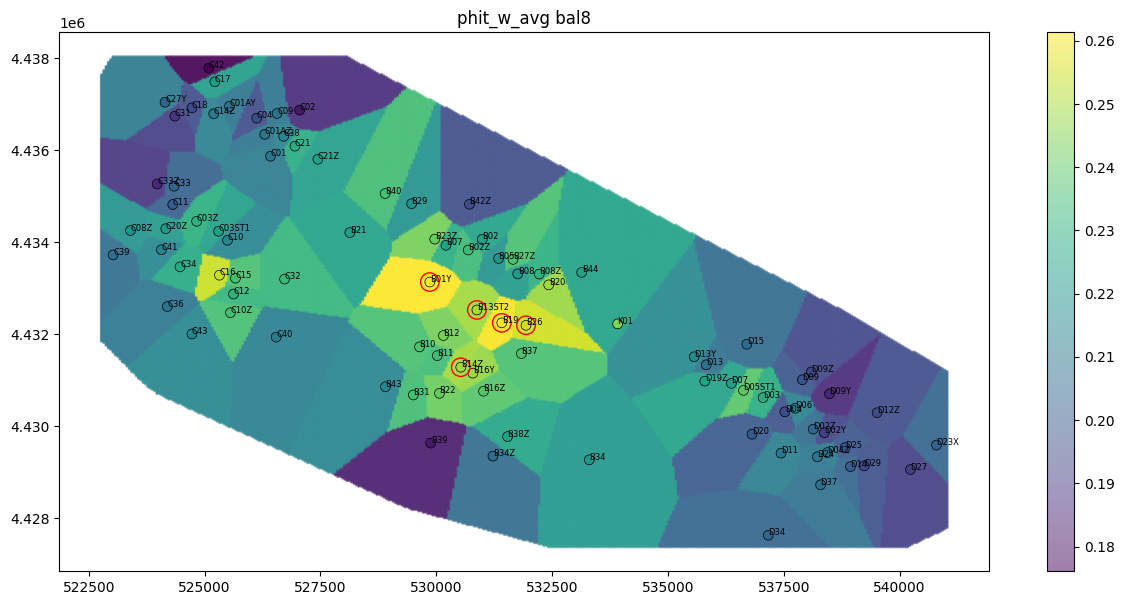

In [ ]:
xy_phit = df_bal8_v4_flag.groupby('well')[['phit','xmean','ymean']].agg({'phit':'mean','xmean':'first','ymean':'first'}).reset_index()
xy_phit = xy_phit.rename(columns={'phit':'phit_w_avg'})
xy_phit_v2 = pd.concat([xy_phit, k01_gb]).reset_index(drop=True)

dist_xy_phit_v2 = pd.DataFrame(euclidean_distances(xy_phit_v2[['xmean', 'ymean']]), columns=list(xy_phit_v2.well))
dist_xy_phit_v3 = pd.concat([dist_xy_phit_v2, xy_phit_v2['well']], axis=1)
k01_dist = dist_xy_phit_v3[dist_xy_phit_v3.well == 'K01'].T
k01_dist = k01_dist.rename(columns={k01_dist.columns[0]:'dist'}).drop('well')
k01_dist.sort_values(by='dist').iloc[0:5]

In [ ]:
print('K01 avg_w_phit:', k01_gb.phit_w_avg.round(3).values[0],
      'avg_phit nn wells:', df_1[df_1.well.isin(['B44','B20', 'D13Y'])].phit_w_avg_true.mean().round(3),
      'diff:', round(k01_gb.phit_w_avg.round(3).values[0] - df_1[df_1.well.isin(['B44','B20', 'D13Y'])].phit_w_avg_true.mean().round(3),3))
print('K01 avg_w_phit:', k01_gb.phit_w_avg.round(3).values[0],
      'avg_phit nn wells:', df_1[df_1.well.isin(['B44','B20', 'B26'])].phit_w_avg_true.mean().round(3),
      'diff:', round(k01_gb.phit_w_avg.round(3).values[0] - df_1[df_1.well.isin(['B44','B20', 'D13Y'])].phit_w_avg_true.mean().round(3),3))

### Low wells investigation

In [ ]:
low_wells = ['C42','B39','D09Y','C02','C33Z', 'C31']
high_wells = ['B16Y','B20','B14Z', 'B13ST2', 'C16', 'B26', 'B01Y', 'B19']

def well_nn_sonic(df_bal8_v4_flag, wellname_1, wellname_2):
    fig, ax = plt.subplots(2,6, figsize=(15,7))
    well_1 = df_bal8_v4_flag[df_bal8_v4_flag.well == wellname_1]
    tvdss1 = well_1.tvd_scs.values
    gr1 = well_1.gr_n.values
    rhob1 = well_1.rhob.values
    npss1 = well_1.npss.values
    son1 = well_1.son.values
    sonsh1 = well_1.sonsh.values
    phit1 = well_1.phit.values
    ax[0,0].plot(gr1, tvdss1, c='green'), ax[0,0].set_xlim(0,150), ax[0,0].grid(), ax[0,0].invert_yaxis()
    ax[0,0].set_title(wellname_1)
    ax[0,1].plot(rhob1, tvdss1, c='red'), ax[0,1].set_xlim(1.95,2.95), ax[0,1].grid(), ax[0,1].invert_yaxis()
    ax[0,2].plot(npss1, tvdss1, c='blue'), ax[0,2].set_xlim(-0.15,0.45), ax[0,2].grid(), ax[0,2].invert_yaxis()
    ax[0,3].plot(son1, tvdss1, c='purple'), ax[0,3].set_xlim(30,130), ax[0,3].grid(), ax[0,3].invert_yaxis()
    ax[0,4].plot(sonsh1, tvdss1, c='orange'), ax[0,4].set_xlim(100,230), ax[0,4].grid(), ax[0,4].invert_yaxis()
    ax[0,5].plot(phit1, tvdss1, c='lightgreen'), ax[0,5].set_xlim(0.3,0), ax[0,5].grid(), ax[0,5].invert_yaxis()
    well_2 = df_bal8_v4_flag[df_bal8_v4_flag.well == wellname_2]
    tvdss2 = well_2.tvd_scs.values
    gr2 = well_2.gr_n.values
    rhob2 = well_2.rhob.values
    npss2 = well_2.npss.values
    son2 = well_2.son.values
    sonsh2 = well_2.sonsh.values
    phit2 = well_2.phit.values
    ax[1,0].plot(gr2, tvdss2, c='green'), ax[1,0].set_xlim(0,150), ax[1,0].grid(), ax[1,0].invert_yaxis()
    ax[1,0].set_title(wellname_2)
    ax[1,1].plot(rhob2, tvdss2, c='red'), ax[1,1].set_xlim(1.95,2.95), ax[1,1].grid(), ax[1,1].invert_yaxis()
    ax[1,2].plot(npss2, tvdss2, c='blue'), ax[1,2].set_xlim(-0.15,0.45), ax[1,2].grid(), ax[1,2].invert_yaxis()
    ax[1,3].plot(son2, tvdss2, c='purple'), ax[0,3].set_xlim(30,130), ax[0,3].grid(), ax[0,3].invert_yaxis()
    ax[1,4].plot(sonsh2, tvdss2, c='orange'), ax[0,4].set_xlim(100,230), ax[0,4].grid(), ax[0,4].invert_yaxis()
    ax[1,5].plot(phit2, tvdss2, c='lightgreen'), ax[1,5].set_xlim(0.3,0), ax[1,5].grid(), ax[1,5].invert_yaxis()
    fig.tight_layout()

# well_nn_sonic(df_bal8_v4_flag, 'C42', 'C17')
# well_nn_sonic(df_bal8_v4_flag, 'C02', 'C09')
# well_nn_sonic(df_bal8_v4_flag, 'B39', 'B43')
well_nn_sonic(df_bal8_v4_flag, 'B22', 'B39')

In [ ]:
import slb_charts as slb
df_bal8_v4_flag['well_type'] = 'norm'
df_bal8_v4_flag.loc[df_bal8_v4_flag.well.isin(low_wells), 'well_type'] = 'low'
df_bal8_v4_flag.loc[df_bal8_v4_flag.well.isin(high_wells), 'well_type'] = 'high'

norm = df_bal8_v4_flag[df_bal8_v4_flag.well_type == 'norm']
norm = norm[(norm.net == 1) & (norm.npss > 0)]
low = df_bal8_v4_flag[df_bal8_v4_flag.well_type == 'low']
low = low[(low.net == 1) & (low.npss > 0)]
high = df_bal8_v4_flag[df_bal8_v4_flag.well_type == 'high']
high = high[(high.net == 1) & (high.npss > 0)]
calcite = df_bal8_v4_flag[df_bal8_v4_flag.calc == 1]
calcite = calcite[(calcite.net == 1) & (calcite.npss > 0)]

snd = slb.slb_cp1cd_nphi_rhob()['snd']
lms = slb.slb_cp1cd_nphi_rhob()['lms']
dol = slb.slb_cp1cd_nphi_rhob()['dol']

labels_coords = [(0.15, 2.3), (.1, 2.5), (0.4, 2.4)]
labels = ['sandstone', 'limestone', 'dolomite']
fig, ax = plt.subplots(figsize=(10,7))
sns.kdeplot(data=low, x='npss', y='rhob', 
            shade=True, cmap="Reds", zorder=3, alpha=0.75, label='low', thresh=0.5, levels=5)
sns.kdeplot(data = high, x='npss', y='rhob', 
            shade=True, cmap="Greens", zorder=2, alpha=0.75, label='high', thresh=0.5, levels=5)
sns.kdeplot(data = calcite, x='npss', y='rhob', 
            shade=True, cmap="Blues", zorder=3, alpha=0.75, label='calcite', thresh=0.5, levels=5)
sns.kdeplot(data = norm, x='npss', y='rhob', 
            shade=True, cmap="Greys", zorder=4, alpha=0.55, label='norm', thresh=0.5, levels=5)
sns.lineplot(data=snd, x='x', y='y', c='green', ls='--')
sns.lineplot(data=lms, x='x', y='y', c='blue', ls='--')
sns.lineplot(data=dol, x='x', y='y', c='red', ls='--')
for point, label in zip(labels_coords, labels):
    ax.annotate(label, point, textcoords="offset points", xytext=(0,10), ha='center')
plt.xlim(-0.05, 0.55)
plt.ylim(2.95, 1.75)
plt.title('Schlumberger, CP-1c & CP-1d, NPHI vs RHOB')
plt.grid()

In [40]:
# RHOmaa and Umaa calculations
# The three measurements from photoelectric factor, density, and neutron porosity logs can be condensed into two variables that 
# are keyed to mineralogy by eliminating porosity.
# RHOmaa is the estimate of the density (RHO) of the mineral matrix (ma), where the final 'a' stands for "apparent," because 
# it is estimated from the logs, rather than measured from core, when it would be termed the grain density. RHOmaa has units of gm/cc.
# Umaa is the bulk photoelectric absorption (U) of the mineral matrix (ma) estimated from the logs (a, apparent). Umaa has units of barns/cc.
# Notice that the photoelectric factor log is recorded in units of barns per electron (b/e) which is not linearly related to mineral volume.
# Consequently it is converted to U, by:
# U = PeF*RHOb
# U now has units of barns/cc.
# In order to eliminate the effect of porosity, we must first estimate its volume, either by using a neutron-density crossplot or 
# by averaging the density and neutron porosity logs:
# phi= (PHID+PHIN)/2
# Now, because the relationship between density and porosity is given by the mass-balance relationship:
# RHOb = phi*RHOf + (1-phi)*RHOma
# then, rearranging to solve for an estimate of the matrix density:
# RHOmaa = (RHOb-phi*RHOf)/(1-phi)
# Similarly for U, the relationship of:
# U = phi*Uf + (1-phi)*Uma
# can be arranged to solve for:
# Umaa = (U-phi*Uf)/(1-phi)
# RHOf is the density of the water in the pore space. Because the density measurement is shallow, most of this fluid will be mud filtrate. 
# If the drilling mud is fresh, the mud filtrate will be fresh water, so RHOf has a value of 1 gm/cc. Uf has a value of about 0.5 barns/cc.
# When RHOmaa and Umaa are calculated for any zone, then the values can be located on a crossplot to determine its mineralogy, as shown next.

pef_ngs = pd.read_csv(r'C:\jupyter\SPP\input\ACG_pef_ngs.csv')[1:].drop(['datasetName'], axis=1)
pef_ngs = pef_ngs.rename(columns={'wellName':'well', 'DEPTH':'MD'})
pef_ngs.columns = pef_ngs.columns.str.lower()
pef_ngs = pef_ngs[['well', 'md','pef', 'pota', 'thor','uran']]
# pef_ngs[pef_ngs.pota.notna()].well.unique()
# ['A02', 'A04', 'A05', 'A07', 'A08', 'A10', 'A12', 'A13', 'A14', 'B01ST1', 'B06', 'C02', 'C05', 'D01', 'D01Z', 'GCA6']

for col in ['md', 'pef', 'pota', 'thor', 'uran']:
    pef_ngs[col] = pd.to_numeric(pef_ngs[col], errors='coerce')
pef_ngs['well'] = pef_ngs['well'].astype('string')
pef_ngs = pef_ngs.round({'md':1, 'tvd_scs':1})
pef_ngs = pef_ngs[pef_ngs.pef > 0].reset_index(drop=True)
pef_ngs_logs = df_bal8_v4_flag.set_index(['well','md']).join(pef_ngs.set_index(['well','md'])).reset_index()
pef_logs = pef_ngs_logs[pef_ngs_logs.pef.notna()]
ngs_logs = pef_ngs_logs[pef_ngs_logs.pota.notna()]
# U = PeF*RHOb
# Umaa = (U-phi*Uf)/(1-phi)
pef_logs['u'] = pef_logs.pef*pef_logs.rhob
Uf = 0.5
RHOf = 1
pef_logs['umaa'] = (pef_logs.u - pef_logs.phit*Uf)/(1-pef_logs.phit)
pef_logs['rhomaa'] = (pef_logs.rhob - pef_logs.phit*RHOf)/(1-pef_logs.phit)

In [ ]:
ngs = pef_ngs[(pef_ngs.pota.notna()) & (pef_ngs.thor.notna()) & (pef_ngs.uran.notna()) & (pef_ngs.uran!=-9999)]
ngs_logs = df_bal8_v4_flag.set_index(['well','md']).join(ngs.set_index(['well','md'])).reset_index()
ngs_logs = ngs_logs[ngs_logs.pota.notna()]
ngs_logs.well.unique()

In [ ]:
norm = pef_logs[pef_logs.well_type == 'norm']
norm = norm[(norm.net == 1) & (norm.npss > 0)]
low = pef_logs[pef_logs.well_type == 'low']
low = low[(low.net == 1) & (low.npss > 0)]
high = pef_logs[pef_logs.well_type == 'high']
high = high[(high.net == 1) & (high.npss > 0)]
calcite = pef_logs[pef_logs.calc == 1]
calcite = calcite[(calcite.net == 1) & (calcite.npss > 0)]

fig, ax = plt.subplots(figsize=(10,7))
sns.kdeplot(data=low, x='umaa', y='rhomaa', 
            shade=True, cmap="Reds", zorder=3, alpha=0.75, label='low', thresh=0.5, levels=5, ax=ax)
sns.kdeplot(data = high, x='umaa', y='rhomaa', 
            shade=True, cmap="Greens", zorder=2, alpha=0.75, label='high', thresh=0.5, levels=5)
sns.kdeplot(data = calcite, x='umaa', y='rhomaa', 
            shade=True, cmap="Blues", zorder=2, alpha=0.75, label='calcite', thresh=0.5, levels=5)
sns.kdeplot(data = norm, x='umaa', y='rhomaa', 
            shade=True, cmap="Greys", zorder=2, alpha=0.55, label='norm', thresh=0.5, levels=5)
u_sft = 5
triangle_coords_orig = [(4.78, 2.65), (9.00, 2.87), (13.8, 2.71)]
labels_orig = ['quartz_orig', 'calcite_orig', 'dolomite_orig']
triangle_coords = [(4.78+u_sft, 2.65), (9.00+u_sft, 2.87), (13.8+u_sft, 2.71)]
labels = ['quartz', 'calcite', 'dolomite']
triangle_orig = patches.Polygon(triangle_coords_orig, closed=True, edgecolor='red', ls='--', facecolor='none')
triangle = patches.Polygon(triangle_coords, closed=True, edgecolor='blue', ls='--', facecolor='none')
ax.add_patch(triangle)
ax.add_patch(triangle_orig)
for point, label in zip(triangle_coords, labels):
    ax.annotate(label, point, textcoords="offset points", xytext=(0,10), ha='center')
for point, label in zip(triangle_coords_orig, labels_orig):
    ax.annotate(label, point, textcoords="offset points", xytext=(0,-10), ha='center')
#gas arrow
plt.annotate('', xy=(8.03+u_sft, 2.38), xytext=(8.17+u_sft, 2.498),arrowprops=dict(facecolor='green', shrink=0.05, width=1))
plt.annotate('gas direction', (8.17+u_sft, 2.498), textcoords="offset points", xytext=(0,-10), ha='center')
#barite arrow
plt.annotate('', xy=(20, 2.8), xytext=(17, 2.8),arrowprops=dict(facecolor='grey', shrink=0.05, width=1))
plt.annotate('barite', (17, 2.8), textcoords="offset points", xytext=(10,-10), ha='center')
plt.ylim(3.15, 2.15)
plt.xlim(2, 26)
plt.title('Schlumberger, LITH-6, Uma vs Rhoma')
plt.grid()

In [ ]:
xy[xy.well.isin(gas_wells_v2.well.unique())]

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Assuming df_bal8_v4_flag, tvdss, and gas_wells_v2 are already defined

sonic_wells = df_bal8_v4_flag[(df_bal8_v4_flag.son != 0)]
sonic_wells_gb = sonic_wells.groupby('well').agg({'son':'mean','sonsh':'mean', 
                                                  'tvd_scs':'mean', 'xmean':'first', 'ymean':'first'}).reset_index()
xy = df_bal8_v4_flag[df_bal8_v4_flag.phit_flag == 1].groupby('well').agg({'xmean':'first', 'ymean':'first', 
                                                                          'tvd_scs':'mean'}).reset_index()
xy['son_virt'] = 100

# Create a figure with a gridspec layout
fig = plt.figure(figsize=(11, 5))
# gs = gridspec.GridSpec(1, 2, height_ratios=[2, 1])  # Adjust height_ratios as needed
gs = gridspec.GridSpec(1, 2, width_ratios=[1,3])

# First subplot (smaller)
ax1 = fig.add_subplot(gs[0])
ax1.scatter(sonic_wells_gb['sonsh'], sonic_wells_gb['tvd_scs'], label='sonsh')
ax1.scatter(sonic_wells_gb['son'], sonic_wells_gb['tvd_scs'], label='son')
ax1.scatter(xy['son_virt'], xy['tvd_scs'], label='all wells', alpha=0.25)
ax1.axhline(y=tvdss[tvdss.well.isin(gas_wells_v2.well.values)].sort_values(by='tvd_scs', ascending=False).iloc[0]['tvd_scs'], 
            color='red', linestyle='--', linewidth=1.5)
for idx, txt in enumerate(sonic_wells_gb.well):
    ax1.annotate(txt, (sonic_wells_gb.son.iloc[idx], sonic_wells_gb.tvd_scs.iloc[idx]), fontsize=6);
ax1.invert_yaxis()
ax1.legend()
# Second subplot (larger)
ax2 = fig.add_subplot(gs[1])
ax2.scatter(xy['xmean'], xy['ymean'], c='green', label='all wells')
ax2.scatter(xy[xy.well.isin(gas_wells_v2.well.unique())]['xmean'], 
            xy[xy.well.isin(gas_wells_v2.well.unique())]['ymean'], c='red', label='gas wells')
ax2.scatter(sonic_wells_gb['xmean'], sonic_wells_gb['ymean'], c='orange', label='sonic wells')
for idx, txt in enumerate(sonic_wells_gb.well):
    ax2.annotate(txt, (sonic_wells_gb.xmean.iloc[idx], sonic_wells_gb.ymean.iloc[idx]), c='black', fontsize=6);
for idx, txt in enumerate(xy[xy.well.isin(gas_wells_v2.well.unique())].well):
    ax2.annotate(txt, (xy[xy.well.isin(gas_wells_v2.well.unique())].xmean.iloc[idx], 
                       xy[xy.well.isin(gas_wells_v2.well.unique())].ymean.iloc[idx]), c='red', fontsize=6);
ax2.legend()
plt.tight_layout()
plt.show()

In [47]:
phit_net_tvdss = df_bal8_v4_flag[df_bal8_v4_flag.net == 1].groupby('well')[['rhob','npss','vsh','phit']].mean().reset_index()
phit_nonot_tvdss = df_bal8_v4_flag[df_bal8_v4_flag.net == 0].groupby('well')[['rhob','npss','vsh','phit']].mean().reset_index()
tvdss = df_bal8_v4_flag.groupby('well')[['tvd_scs']].mean().reset_index()
phit_net_tvdss = phit_net_tvdss.merge(tvdss, on='well')
phit_nonot_tvdss = phit_nonot_tvdss.merge(tvdss, on='well')

In [ ]:
def low_wells_logs_analize():
    low_wells = ['C42','B39','D09Y','C02','C33Z', 'C31']
    high_wells = ['B16Y','B20','B14Z', 'B13ST2', 'C16', 'B26', 'B01Y', 'B19']
    # high_wells = ['B13ST2', 'B14Z', 'B19']
    # high_wells = gas_wells_v2.well.values

    phit_net_tvdss_out = phit_net_tvdss[phit_net_tvdss.well.isin(low_wells)]
    phit_nonot_tvdss_out = phit_nonot_tvdss[phit_nonot_tvdss.well.isin(low_wells)]
    phit_net_tvdss_high = phit_net_tvdss[phit_net_tvdss.well.isin(high_wells)]
    phit_nonot_tvdss_high = phit_nonot_tvdss[phit_nonot_tvdss.well.isin(high_wells)]
    
    tvdss_net = phit_net_tvdss.tvd_scs.values
    tvdss_net_out = phit_net_tvdss_out.tvd_scs.values
    tvdss_net_high = phit_net_tvdss_high.tvd_scs.values

    tvdss_nonot = phit_nonot_tvdss.tvd_scs.values
    tvdss_nonot_out = phit_nonot_tvdss_out.tvd_scs.values
    tvdss_nonot_high = phit_net_tvdss_high.tvd_scs.values

    phit_net = phit_net_tvdss.phit.values
    phit_net_out = phit_net_tvdss_out.phit.values
    phit_net_high = phit_net_tvdss_high.phit.values

    phit_nonot = phit_nonot_tvdss.phit.values
    phit_nonot_out = phit_nonot_tvdss_out.phit.values
    phit_nonot_high = phit_nonot_tvdss_high.phit.values

    rhob_net = phit_net_tvdss.rhob.values
    rhob_net_out = phit_net_tvdss_out.rhob.values
    rhob_nonot = phit_nonot_tvdss.rhob.values
    rhob_nonot_out = phit_nonot_tvdss_out.rhob.values

    npss_net = phit_net_tvdss.npss.values
    npss_net_out = phit_net_tvdss_out.npss.values
    npss_nonot = phit_nonot_tvdss.npss.values
    npss_nonot_out = phit_nonot_tvdss_out.npss.values

    vsh_net = phit_net_tvdss.vsh.values
    vsh_net_out = phit_net_tvdss_out.vsh.values
    vsh_nonot = phit_nonot_tvdss.vsh.values
    vsh_nonot_out = phit_nonot_tvdss_out.vsh.values

    fig, ax = plt.subplots(1,4, figsize=(15,5))
    ax[0].scatter(phit_net, tvdss_net, c='orange', ec='gray', lw=0.5, alpha=0.5), ax[0].set_xlim(0.3,0.1), ax[0].grid(), ax[0].invert_yaxis(), ax[0].set_title('phit')
    ax[0].scatter(phit_net_out, tvdss_net_out, c='orange', ec='red', lw=1.5, alpha=0.5), ax[0].set_xlim(0.3,0.1)
    ax[0].scatter(phit_net_high, tvdss_net_high, c='orange', ec='blue', lw=1.5, alpha=0.5), ax[0].set_xlim(0.3,0.1)
    ax[0].scatter(phit_nonot, tvdss_nonot, c='green', ec='gray', lw=0.5, alpha=0.5), ax[0].set_xlim(0.3,0.1), ax[0].grid()
    ax[0].scatter(phit_nonot_out, tvdss_nonot_out, c='green', ec='red', lw=2, alpha=0.5), ax[0].set_xlim(0.3,0.1), ax[0].grid()
    ax[0].scatter(phit_nonot_high, tvdss_nonot_high, c='green', ec='blue', lw=2, alpha=0.5), ax[0].set_xlim(0.3,0.1)
    ax[0].axhline(y=tvdss[tvdss.well.isin(gas_wells_v2.well.values)].sort_values(by='tvd_scs', ascending=False).iloc[0]['tvd_scs'], 
                color='red', linestyle='--', linewidth=1.5)

    ax[1].scatter(rhob_net, tvdss_net, c='red', ec='gray', lw=0.5, alpha=0.5), ax[1].set_xlim(1.95,2.95), ax[2].grid(), ax[1].invert_yaxis(), ax[1].set_title('rhob')
    ax[1].scatter(rhob_net_out, tvdss_net_out, c='red', ec='black', lw=2, alpha=0.5), ax[1].set_xlim(1.95,2.95), ax[1].grid()
    ax[1].scatter(rhob_nonot, tvdss_nonot, c='red', ec='gray', lw=0.5, alpha=0.5), ax[1].set_xlim(1.95,2.95), ax[1].grid()
    ax[1].scatter(rhob_nonot_out, tvdss_nonot_out, c='red', ec='black', lw=2, alpha=0.5), ax[1].set_xlim(1.95,2.95), ax[1].grid()
    ax[1].axhline(y=tvdss[tvdss.well.isin(gas_wells_v2.well.values)].sort_values(by='tvd_scs', ascending=False).iloc[0]['tvd_scs'], 
                color='red', linestyle='--', linewidth=1.5)

    ax[2].scatter(npss_net, tvdss_net, c='blue', ec='gray', lw=0.5, alpha=0.5), ax[2].set_xlim(0,0.45), ax[2].grid(), ax[2].invert_yaxis(), ax[2].set_title('npss')
    ax[2].scatter(npss_net_out, tvdss_net_out, c='blue', ec='red', lw=2, alpha=0.5), ax[2].set_xlim(0,0.45), ax[2].grid()
    ax[2].scatter(npss_nonot, tvdss_nonot, c='lightblue', ec='gray', lw=0.5, alpha=0.5), ax[2].set_xlim(0,0.45), ax[2].grid()
    ax[2].scatter(npss_nonot_out, tvdss_nonot_out, c='lightblue', ec='purple', lw=2, alpha=0.5), ax[2].set_xlim(0,0.45), ax[2].grid()
    ax[2].axhline(y=tvdss[tvdss.well.isin(gas_wells_v2.well.values)].sort_values(by='tvd_scs', ascending=False).iloc[0]['tvd_scs'], 
                color='red', linestyle='--', linewidth=1.5)

    ax[3].scatter(vsh_net, tvdss_net, c='gray', ec='gray', lw=0.5, alpha=0.5), ax[3].set_xlim(0,1), ax[3].grid(), ax[3].invert_yaxis(), ax[3].set_title('vsh_net')
    ax[3].scatter(vsh_net_out, tvdss_net_out, c='gray', ec='red', lw=2, alpha=0.5), ax[3].set_xlim(0,1)
    ax[3].scatter(vsh_nonot, tvdss_nonot, c='gray', ec='black', lw=0.5, alpha=0.5), ax[3].set_xlim(0,1), ax[3].grid()
    ax[3].scatter(vsh_nonot_out, tvdss_nonot_out, c='gray', ec='red', lw=2, alpha=0.5), ax[3].set_xlim(0,1), ax[3].grid()

    for idx, txt in enumerate(phit_net_tvdss_out.well):
        ax[0].annotate(txt, (phit_net_tvdss_out.phit.iloc[idx], phit_net_tvdss_out.tvd_scs.iloc[idx]), c='red', fontsize=6)
    for idx, txt in enumerate(phit_net_tvdss_high.well):
        ax[0].annotate(txt, (phit_net_tvdss_high.phit.iloc[idx], phit_net_tvdss_high.tvd_scs.iloc[idx]), c='blue', fontsize=6)

low_wells_logs_analize()

In [ ]:
k01 = pd.read_csv(r'C:\jupyter\SPP\input\ACG_k01.csv')[1:].drop('datasetName', axis=1)
k01 = k01.rename(columns={'wellName':'well'})
k01 = k01[k01.FORMATION.isin(['Balakhany VIII sand', 'Balakhany VIII 20','Balakhany VIII 15', 'Balakhany VIII 10', 'Balakhany VIII 5'])]
k01['FORMATION_up'] = 'Balakhany VIII'
k01['field'] = 'ACE'
for col in [    'MD', 'AREA', 'BADPORLOG', 'FLANK', 'Fluidcode',
                'FLUIDCODE_PP', 'GR_N', 'GRMATRIX', 'GRSHALE', 'LPERM',
                'LPERM_DS_Bal', 'LPERM_US_Bal', 'NET', 'NPSS', 'PHIT', 'RDEEP', 'RHOB',
                'RHOF', 'RHOMA', 'TST', 'TVD_SCS', 'X', 'Y']:
    k01[col] = pd.to_numeric(k01[col], errors='coerce')
k01 = k01[(k01.PHIT > 0)]
k01 = k01.round({'MD':1, 'TVD_SCS':1, 'TST':1, 'X':0, 'Y':0})
for col in ['well', 'FORMATION', 'FORMATION_up', 'field']:
    k01[col] = k01[col].astype('string')

def interpolate_by_depth_fm_run_v2(df, step):
    df_tst = df[df.TST.notna()].round({'MD':1})
    
    def interpolate_by_depth_fm_v2(one_well, step):
        one_well = one_well.sort_values(by='TST')
        well_name = one_well["well"].iloc[0]
        formation = one_well["FORMATION"].iloc[0]
        formation_up = one_well["FORMATION_up"].iloc[0]
        field = one_well["field"].iloc[0]
        data_range = np.floor((one_well["TST"].max() - one_well["TST"].min())/step)
        starting_tst = one_well["TST"].iloc[0]
        new_TST_values = [starting_tst + i*0.1 for i in range(1,int(data_range))]
        col_lst = []
        for col in one_well.columns:
            if col not in ['well','FORMATION_up', 'FORMATION','field']:
                interp = interp1d(one_well['TST'], one_well[col], kind='linear', fill_value="extrapolate")
                new_data = {col: interp(new_TST_values)}
                new_df = pd.DataFrame(new_data)
                col_lst.append(new_df)
        new_df = pd.concat(col_lst, axis=1)
        new_df['well'] = well_name
        new_df['TST'] = new_TST_values
        # new_df['FORMATION'] = formation
        # new_df['FORMATION_up'] = formation_up
        # new_df['field'] = field #Index(['FORMATION', 'FORMATION_up', 'field'], dtype='object')
        # new_df = new_df[[   'well', 
        #                     'TST', 'tst_index', 'MD',  'DEVI', 'HAZI', 'NET', 'NET_VSH', 'LPERM',
        #                     'PHIT', 'GR_N', 'VSH', 'NPSS', 'RHOB', 'RDEEP', 'SON', 'SONSH',
        #                     'TVD_SCS', 'X_traj', 'Y_traj', 'Xmean', 'Ymean', 'RHOF', 'RHOMA',
        #                     'tst_sample', 'NET_clp', 'NET_clp2', 'phit_flag', 'PERM_DS', 'PERM_US',
        #                     'k_htst', 'KHtst', 'VSH_smooth', 'NET_smooth', 'NET_orig',
        #                     'NET_VSH_orig', 'TST_interv', 'TST_interv_fu', 'fluid_code', 'calc',
        #                     'calc_net', 'phitd_npss']]
        return new_df
    df_lst = []
    for well in tqdm(df_tst.well.unique()):
        well_data = df_tst[df_tst.well == well]
        well_data_interp = interpolate_by_depth_fm_v2(well_data, 0.1)
        df_lst.append(well_data_interp)
    df_interp = pd.concat(df_lst)
    df_interp = df_interp.round({'MD':1, 'TVD_SCS':1, 'TST':1})
    print('Start joining')
    def well_bal_interp_join(dataset):
        df_tst = df[(df.TST.notna()) & (df.FORMATION_up.notna())].round({'MD':1})
        data_fu = df_tst[['well','MD','FORMATION_up', 'FORMATION', 'field']]
        well_join = dataset.set_index(['well','MD']).join(data_fu.set_index(['well','MD'])).reset_index()
        well_join.insert(3, 'FORMATION_up', well_join.pop('FORMATION_up'))
        well_join.insert(4, 'FORMATION', well_join.pop('FORMATION'))
        # well_join.insert(5, 'tst_index', well_join.pop('tst_index'))
        return well_join
    well_interp_v2 = well_bal_interp_join(df_interp)
    # well_interp_v2.loc[well_interp_v2.NET_VSH > 0, 'NET_VSH'] = 1
    # well_interp_v2.loc[well_interp_v2.NET > 0, 'NET'] = 1
    
    df_lst_2 = []
    for well in well_interp_v2.well.unique():
        field_data = well_interp_v2[well_interp_v2.well == well]
        field_data.field = field_data.field.fillna(method = 'ffill')
        field_data.field = field_data.field.fillna(method = 'bfill')
        field_data.FORMATION_up = field_data.FORMATION_up.fillna(method = 'ffill')
        field_data.FORMATION_up = field_data.FORMATION_up.fillna(method = 'bfill')
        field_data.FORMATION = field_data.FORMATION.fillna(method = 'ffill')
        field_data.FORMATION = field_data.FORMATION.fillna(method = 'bfill')
        df_lst_2.append(field_data)
    well_interp_v3 = pd.concat(df_lst_2)

    return well_interp_v3

k01_intepr = interpolate_by_depth_fm_run_v2(k01, 0.1)
k01_intepr.columns = k01_intepr.columns.str.lower()
k01_intepr['son'] = 0
k01_intepr['sonsh'] = 0
k01_intepr['xmean'] = k01_intepr.x.mean()
k01_intepr['ymean'] = k01_intepr.y.mean()
k01_gb = k01_intepr[k01_intepr.net==1].groupby('well')[['phit', 'xmean', 'ymean']].mean().reset_index()
k01_gb = k01_gb.rename(columns={'phit':'phit_w_avg'})

In [ ]:
def intersection_maps(map, wells, buffer):
    geometry_map = [Point(xy) for xy in zip(map['x'], map['y'])]
    gdf_map = gpd.GeoDataFrame(map, geometry=geometry_map)

    geometry_points = [Point(xy) for xy in zip(wells['xmean'], wells['ymean'])]
    gdf_points = gpd.GeoDataFrame(wells, geometry=geometry_points)
    convex_hull = gdf_points.unary_union.convex_hull.buffer(buffer)
    intersection = gdf_map[gdf_map.intersects(convex_hull)]
    return intersection
nn_w_phit_map8_v2 = pd.read_csv('C:/jupyter/SPP/inputoutput/nn_w_phit_map8_v2.csv')
intersection_phit8 = intersection_maps(nn_w_phit_map8_v2, ntd8, 1500)
anomaly_gas_wells = ntd8[ntd8.well.isin(['B01Y','B13ST2','B14Z','B19','B26'])]

fig, ax = plt.subplots(figsize=(15,7))
ntd8_k01 = pd.concat([ntd8, k01_gb]).reset_index(drop=True)
sc = plt.scatter(intersection_phit8.x, intersection_phit8.y, s=2, c=intersection_phit8.phit_avg, cmap='viridis', alpha=0.5)
plt.colorbar(sc)
plt.scatter(ntd8_k01.xmean, ntd8_k01.ymean, s=50, c=ntd8_k01.phit_w_avg, marker='o', ec='black', cmap='viridis', lw=0.5)
plt.title('phit_w_avg bal8')
for idx, txt in enumerate(ntd8_k01.well):
    ax.annotate(txt, (ntd8_k01.xmean.iloc[idx], ntd8_k01.ymean.iloc[idx]), fontsize=6);
for (xi, yi) in anomaly_gas_wells[['xmean', 'ymean']].values:
    circle = Circle((xi, yi), 200, color='r', fill=False)
    ax.add_patch(circle);

### ml + kriging

In [ ]:
def ml_kriging_no_features():
    def ml_kriging_prediction_bal8(models, random_state_value, test_size_value):
        feature_bal8 = ntd8[['well','htst']].values.reshape(-1,2)
        coord_bal8 = ntd8[['xmean', 'ymean']].values
        target_bal8 = ntd8['phit_w_avg'].values

        f_train, f_test, xy_train, xy_test, target_train, target_test = train_test_split(
            feature_bal8, coord_bal8, target_bal8, test_size=test_size_value, random_state=random_state_value
        )

        def model_mlkrige_run(f_train, f_test, xy_train, xy_test, target_train, target_test, models):
            df_final_lst = []
            for m in models:
                reg_score_lst, rk_score_lst, nn_lst, m_lst = [], [], [], []
                for nn in range(2,16):
                    print("n_closest_points:", nn)
                    m_rk = RegressionKriging(regression_model=m, n_closest_points=nn, verbose=False)
                    m_rk.fit(f_train[:,1:], xy_train, target_train)
                    reg_score_lst.append(m_rk.regression_model.score(f_test[:,1:], target_test))
                    rk_score_lst.append(m_rk.score(f_test[:,1:], xy_test, target_test))
                    nn_lst.append(nn)
                    m_lst.append(m)
                result = pd.DataFrame({'model':m_lst,'n_closest_points':nn_lst, 'reg_score':reg_score_lst,'rk_score':rk_score_lst})
                result['random_state'] = random_state_value
                result['test_size'] = test_size_value
                df_final_lst.append(result)
                df_final = pd.concat(df_final_lst)
            return df_final
        ml_kriging = model_mlkrige_run(f_train, f_test, xy_train, xy_test, target_train, target_test, models)

        def model_mlkrige_best_res(f_train, f_test, xy_train, xy_test, target_train, target_test, models_df):
            model_sorted = models_df.sort_values(by='rk_score', ascending=False)
            model_name = model_sorted.iloc[0]['model']
            nn_points = model_sorted.iloc[0]['n_closest_points']
            m_rk = RegressionKriging(regression_model=model_name, n_closest_points=nn_points)
            m_rk.fit(f_train[:,1:], xy_train, target_train)

            pred = m_rk.predict(f_test[:,1:], xy_test)
            pred_df = pd.DataFrame(zip(pred, target_test), columns=['phit_w_avg_pred', 'phit_w_avg_true'])
            pred_df['well'] = f_test[:,0]
            pred_df['model'] = model_name
            pred_df['n_closest_points'] = nn_points
            pred_df['random_state'] = random_state_value
            pred_df['test_size'] = test_size_value
            pred_df['up_1.15pu'] = pred_df.phit_w_avg_true+0.0115
            pred_df['down_1.15pu'] = pred_df.phit_w_avg_true-0.0115
            pred_df['qc'] = np.where((pred_df.phit_w_avg_pred >= pred_df['down_1.15pu']) & (pred_df.phit_w_avg_pred <= pred_df['up_1.15pu']), 1, 0)
            return pred_df
        prediction_df = model_mlkrige_best_res(f_train, f_test, xy_train, xy_test, target_train, target_test, ml_kriging)

        return prediction_df, ml_kriging

    svr_model = SVR()
    rf_model = RandomForestRegressor()
    lr_model = LinearRegression()

    models_test = [svr_model, rf_model, lr_model]
    prediction_df_nof, ml_kriging_nof = ml_kriging_prediction_bal8(models_test, 42, 0.5)
    qc_calc_mlk_nof = prediction_df_nof.qc.value_counts(normalize=True).reset_index()
    custom_palette = {0: 'red', 1: 'green'}
    sns.scatterplot(data=prediction_df_nof, x='phit_w_avg_true', y='phit_w_avg_pred', s=30, hue='qc', alpha=0.5, ec='black', palette=custom_palette)
    sns.lineplot(x=[0.16,0.27], y=[0.16,0.27], color='blue', ls='--')
    plt.title('qc = 1 ' + str(qc_calc_mlk_nof[qc_calc_mlk_nof.qc==1]['proportion'].values[0].round(2)))
    plt.grid()
    for idx, txt in enumerate(prediction_df_nof.well):
        plt.annotate(txt, (prediction_df_nof.phit_w_avg_true[idx], prediction_df_nof.phit_w_avg_pred[idx]), fontsize=6)
    return qc_calc_mlk_nof, prediction_df_nof, ml_kriging_nof

qc_calc_mlk_nof, pred_ml_kri_nof_df, ml_kri_nof = ml_kriging_no_features()
pred_ml_kri_nof_df['type'] = 'ml_kriging_no_features'
# pred_ml_nof_df

### ml

In [ ]:
def ml_no_features():
    ml_model_nof = RandomForestRegressor()

    feature_bal8 = ntd8[['well','htst']].values.reshape(-1,2)
    coord_bal8 = ntd8[['xmean', 'ymean']].values
    target_bal8 = ntd8['phit_w_avg'].values

    f_train, f_test, xy_train, xy_test, target_train, target_test = train_test_split(
        feature_bal8, coord_bal8, target_bal8, test_size=0.5, random_state=42
    )
    ml_model_nof.fit(f_train[:,1:], target_train)
    pred_ml_nof = ml_model_nof.predict(f_test[:,1:])
    pred_ml_nof_df = pd.DataFrame(zip(pred_ml_nof, target_test), columns=['phit_w_avg_pred', 'phit_w_avg_true'])
    pred_ml_nof_df['well'] = f_test[:,0]
    pred_ml_nof_df['model'] = ml_model_nof.__class__.__name__
    # pred_svr_df['n_closest_points'] = nn_points
    pred_ml_nof_df['random_state'] = 42
    pred_ml_nof_df['test_size'] = 0.5
    pred_ml_nof_df['up_1.15pu'] = pred_ml_nof_df.phit_w_avg_true+0.0115
    pred_ml_nof_df['down_1.15pu'] = pred_ml_nof_df.phit_w_avg_true-0.0115
    pred_ml_nof_df['qc'] = np.where((pred_ml_nof_df.phit_w_avg_pred >= pred_ml_nof_df['down_1.15pu']) & (pred_ml_nof_df.phit_w_avg_pred <= pred_ml_nof_df['up_1.15pu']), 1, 0)

    qc_calc_ml_nof = pred_ml_nof_df.qc.value_counts(normalize=True).reset_index()
    custom_palette = {0: 'red', 1: 'green'}
    sns.scatterplot(data=pred_ml_nof_df, x='phit_w_avg_true', y='phit_w_avg_pred', s=30, hue='qc', alpha=0.5, ec='black', palette=custom_palette)
    sns.lineplot(x=[0.16,0.27], y=[0.16,0.27], color='blue', ls='--')
    plt.title('qc = 1 ' + str(qc_calc_ml_nof[qc_calc_ml_nof.qc==1]['proportion'].values[0].round(2)))
    plt.grid()
    for idx, txt in enumerate(pred_ml_nof_df.well):
        plt.annotate(txt, (pred_ml_nof_df.phit_w_avg_true[idx], pred_ml_nof_df.phit_w_avg_pred[idx]), fontsize=6)
    
    return qc_calc_ml_nof, pred_ml_nof_df

qc_calc_ml_nof, pred_ml_nof_df = ml_no_features()
pred_ml_nof_df['type'] = 'ml_no_features'

### kriging

In [ ]:
def kriging_no_features():
    feature_bal8 = ntd8[['htst']].values.reshape(-1,1)
    coord_bal8 = ntd8[['well','xmean', 'ymean']].values
    target_bal8 = ntd8['phit_w_avg'].values

    f_train, f_test, xy_train, xy_test, target_train, target_test = train_test_split(
        feature_bal8, coord_bal8, target_bal8, test_size=0.5, random_state=42)

    kriging_nof = Krige(n_closest_points=2, method='ordinary', variogram_model='linear')
    kriging_nof.fit(x=xy_train[:,1:], y=target_train)
    pred_kriging_nof = kriging_nof.predict(xy_test[:,1:])

    kriging_nof_df = pd.DataFrame(zip(pred_kriging_nof, target_test), columns=['phit_w_avg_pred', 'phit_w_avg_true'])
    kriging_nof_df['well'] = xy_test[:,0]
    kriging_nof_df['model'] = kriging_nof.__class__.__name__
    kriging_nof_df['n_closest_points'] = 2
    kriging_nof_df['random_state'] = 42
    kriging_nof_df['test_size'] = 0.5
    kriging_nof_df['up_1.15pu'] = kriging_nof_df.phit_w_avg_true+0.0115
    kriging_nof_df['down_1.15pu'] = kriging_nof_df.phit_w_avg_true-0.0115
    kriging_nof_df['qc'] = np.where((kriging_nof_df.phit_w_avg_pred >= kriging_nof_df['down_1.15pu']) & (kriging_nof_df.phit_w_avg_pred <= kriging_nof_df['up_1.15pu']), 1, 0)

    qc_calc_k_nof = kriging_nof_df.qc.value_counts(normalize=True).reset_index()
    custom_palette = {0: 'red', 1: 'green'}
    sns.scatterplot(data=kriging_nof_df, x='phit_w_avg_true', y='phit_w_avg_pred', s=30, hue='qc', alpha=0.5, ec='black', palette=custom_palette)
    sns.lineplot(x=[0.16,0.27], y=[0.16,0.27], color='blue', ls='--')
    plt.title('qc = 1 ' + str(qc_calc_k_nof[qc_calc_k_nof.qc==1]['proportion'].values[0].round(2)))
    plt.grid()
    for idx, txt in enumerate(kriging_nof_df.well):
        plt.annotate(txt, (kriging_nof_df.phit_w_avg_true[idx], kriging_nof_df.phit_w_avg_pred[idx]), fontsize=6)
    
    return qc_calc_k_nof, kriging_nof_df

qc_calc_k_nof, pred_kri_nof_df = kriging_no_features()
pred_kri_nof_df['type'] = 'kriging_no_features'

## conclusions no feature

In [ ]:
print('phit_w_avg prediction no features \nkriging:', qc_calc_k_nof[qc_calc_k_nof.qc==1]['proportion'].values[0].round(3), 
      'ml:', qc_calc_ml_nof[qc_calc_ml_nof.qc==1]['proportion'].values[0].round(3), 
      'ml + kriging:', qc_calc_mlk_nof[qc_calc_mlk_nof.qc==1]['proportion'].values[0].round(3),
      'phit_simple_avg', qc_calc_nn_avg_phit[qc_calc_nn_avg_phit.qc==1]['proportion'].values[0].round(3))

In [ ]:
df_no_features = pd.concat([pred_kri_nof_df, pred_ml_nof_df, pred_ml_kri_nof_df]).reset_index(drop=True)
df_no_features

## 1 simple feature

In [56]:
ntd8['gas_well'] = False
ntd8.loc[ntd8.well.isin(names_gas_wells_v2), 'gas_well'] = True

### ml+kriging

In [ ]:
def ml_kriging_feature_1():
    def ml_kriging_prediction_feature_bal8(models, random_state_value, test_size_value):
        feature_bal8 = ntd8[['well','htst','field_CENTRAL AZERI', 'field_EAST AZERI', 'field_WEST AZERI', 'gas_well']].values.reshape(-1,6)
        coord_bal8 = ntd8[['xmean', 'ymean']].values
        target_bal8 = ntd8['phit_w_avg'].values

        f_train, f_test, xy_train, xy_test, target_train, target_test = train_test_split(
            feature_bal8, coord_bal8, target_bal8, test_size=test_size_value, random_state=random_state_value
        )

        def model_mlkrige_run(f_train, f_test, xy_train, xy_test, target_train, target_test, models):
            df_final_lst = []
            for m in models:
                reg_score_lst, rk_score_lst, nn_lst, m_lst = [], [], [], []
                for nn in range(2,16):
                    print("n_closest_points:", nn)
                    m_rk = RegressionKriging(regression_model=m, n_closest_points=nn, verbose=False)
                    m_rk.fit(f_train[:,1:], xy_train, target_train) #f_train[:,1:]
                    reg_score_lst.append(m_rk.regression_model.score(f_test[:,1:], target_test))
                    rk_score_lst.append(m_rk.score(f_test[:,1:], xy_test, target_test))
                    nn_lst.append(nn)
                    m_lst.append(m)
                result = pd.DataFrame({'model':m_lst,'n_closest_points':nn_lst, 'reg_score':reg_score_lst,'rk_score':rk_score_lst})
                result['random_state'] = random_state_value
                result['test_size'] = test_size_value
                df_final_lst.append(result)
                df_final = pd.concat(df_final_lst)
            return df_final
        ml_kriging = model_mlkrige_run(f_train, f_test, xy_train, xy_test, target_train, target_test, models)

        def model_mlkrige_best_res(f_train, f_test, xy_train, xy_test, target_train, target_test, models_df):
            model_sorted = models_df.sort_values(by='rk_score', ascending=False)
            model_name = model_sorted.iloc[0]['model']
            nn_points = model_sorted.iloc[0]['n_closest_points']
            m_rk = RegressionKriging(regression_model=model_name, n_closest_points=nn_points)
            m_rk.fit(f_train[:,1:], xy_train, target_train)

            pred = m_rk.predict(f_test[:,1:], xy_test)
            pred_df = pd.DataFrame(zip(pred, target_test), columns=['phit_w_avg_pred', 'phit_w_avg_true'])
            pred_df['model'] = model_name.__class__.__name__
            pred_df['well'] = f_test[:,0]
            pred_df['n_closest_points'] = nn_points
            pred_df['random_state'] = random_state_value
            pred_df['test_size'] = test_size_value
            pred_df['up_1.15pu'] = pred_df.phit_w_avg_true+0.0115
            pred_df['down_1.15pu'] = pred_df.phit_w_avg_true-0.0115
            pred_df['qc'] = np.where((pred_df.phit_w_avg_pred >= pred_df['down_1.15pu']) & (pred_df.phit_w_avg_pred <= pred_df['up_1.15pu']), 1, 0)
            return pred_df
        prediction_df = model_mlkrige_best_res(f_train, f_test, xy_train, xy_test, target_train, target_test, ml_kriging)

        return prediction_df, ml_kriging

    svr_model = SVR()
    rf_model = RandomForestRegressor()
    lr_model = LinearRegression()
    models_test = [svr_model, rf_model, lr_model]
    prediction_f_df, ml_f_kriging = ml_kriging_prediction_feature_bal8(models_test, 42, 0.5)
    qc_calc_ml_k_f = prediction_f_df.qc.value_counts(normalize=True).reset_index()
    custom_palette = {0: 'red', 1: 'green'}
    sns.scatterplot(data=prediction_f_df, x='phit_w_avg_true', y='phit_w_avg_pred', s=30, hue='qc', alpha=0.5, ec='black', palette=custom_palette)
    sns.lineplot(x=[0.18,0.27], y=[0.18,0.27], color='blue', ls='--')
    plt.title('ml + kriging qc = 1 ' + str(qc_calc_ml_k_f[qc_calc_ml_k_f.qc==1]['proportion'].values[0].round(2)))
    plt.grid()
    for idx, txt in enumerate(prediction_f_df.well):
        plt.annotate(txt, (prediction_f_df.phit_w_avg_true.iloc[idx], prediction_f_df.phit_w_avg_pred.iloc[idx]), fontsize=6)
    return qc_calc_ml_k_f, prediction_f_df, ml_f_kriging

qc_calc_ml_k_f, pred_ml_kri_f_df, ml_kri_f = ml_kriging_feature_1()
pred_ml_kri_f_df['type'] = 'ml_kriging_feature_1'

In [ ]:
sns.scatterplot(data=ml_kri_f, x='rk_score', y='reg_score', hue='model')

### ml

In [ ]:
def ml_feature_1_v1():
    ml_model_f = LinearRegression(fit_intercept=False)
    xy = df_bal8_v4_flag.groupby('well')[['xmean','ymean']].first().reset_index()
    dist_bal8_v5 = dist_bal8_v4.merge(xy, on='well').round({'xmean':0, 'ymean':0})
    dist_bal8_v5.columns

    feature_bal8 = ntd8[['well','htst','field_CENTRAL AZERI', 'field_EAST AZERI', 'field_WEST AZERI', 'gas_well']].values.reshape(-1,6)
    coord_bal8 = ntd8[['xmean', 'ymean']].values
    target_bal8 = ntd8['phit_w_avg'].values

    f_train, f_test, xy_train, xy_test, target_train, target_test = train_test_split(
        feature_bal8, coord_bal8, target_bal8, test_size=0.5, random_state=42
    )
    ml_model_f.fit(f_train[:,1:], target_train)
    pred_ml_f = ml_model_f.predict(f_test[:,1:])
    pred_ml_f_df = pd.DataFrame(zip(pred_ml_f, target_test), columns=['phit_w_avg_pred', 'phit_w_avg_true'])
    pred_ml_f_df['well'] = f_test[:,0]
    pred_ml_f_df['gas_well'] = f_test[:,5]
    pred_ml_f_df['model'] = ml_model_f.__class__.__name__
    # pred_svr_df['n_closest_points'] = nn_points
    pred_ml_f_df['random_state'] = 42
    pred_ml_f_df['test_size'] = 0.5
    pred_ml_f_df['up_1.15pu'] = pred_ml_f_df.phit_w_avg_true+0.0115
    pred_ml_f_df['down_1.15pu'] = pred_ml_f_df.phit_w_avg_true-0.0115
    pred_ml_f_df['qc'] = np.where((pred_ml_f_df.phit_w_avg_pred >= pred_ml_f_df['down_1.15pu']) & (pred_ml_f_df.phit_w_avg_pred <= pred_ml_f_df['up_1.15pu']), 1, 0)

    score_ml = ml_model_f.score(f_test[:,1:], target_test)
    qc_calc_ml_f = pred_ml_f_df.qc.value_counts(normalize=True).reset_index()
    custom_palette = {0: 'red', 1: 'green'}
    sns.scatterplot(data=pred_ml_f_df, x='phit_w_avg_true', y='phit_w_avg_pred', s=30, hue='qc', style='gas_well', alpha=0.5, ec='black', palette=custom_palette)
    sns.lineplot(x=[0.18,0.27], y=[0.18,0.27], color='blue', ls='--')
    plt.title('only ml qc = 1 ' + str(qc_calc_ml_f[qc_calc_ml_f.qc==1]['proportion'].values[0].round(2)) + ' / R2: ' + str(round(score_ml,2)))
    plt.grid()
    for idx, txt in enumerate(pred_ml_f_df.well):
        plt.annotate(txt, (pred_ml_f_df.phit_w_avg_true[idx], pred_ml_f_df.phit_w_avg_pred[idx]), fontsize=6)
    
    return qc_calc_ml_f, pred_ml_f_df

qc_calc_ml_f, pred_ml_f_df = ml_feature_1_v1()
pred_ml_f_df['type'] = 'ml_feature_1'

In [ ]:
def ml_feature_1_v2():
    ml_model_f_v2 = RandomForestRegressor()

    feature_bal8 = ntd8[['well','htst','field_CENTRAL AZERI', 'field_EAST AZERI', 'field_WEST AZERI', 'gas_well']].values.reshape(-1,6)
    coord_bal8 = ntd8[['xmean', 'ymean']].values
    target_bal8 = ntd8['phit_w_avg'].values

    f_train, f_test, xy_train, xy_test, target_train, target_test = train_test_split(
        feature_bal8, coord_bal8, target_bal8, test_size=0.5, random_state=42
    )
    ml_model_f_v2.fit(f_train[:,1:], target_train)
    pred_ml_f_v2 = ml_model_f_v2.predict(f_test[:,1:])
    pred_ml_f_v2_df = pd.DataFrame(zip(pred_ml_f_v2, target_test), columns=['phit_w_avg_pred', 'phit_w_avg_true'])
    pred_ml_f_v2_df['model'] = ml_model_f_v2.__class__.__name__
    pred_ml_f_v2_df['well'] = f_test[:,0]
    pred_ml_f_v2_df['gas_well'] = f_test[:,5]
    # pred_svr_df['n_closest_points'] = nn_points
    pred_ml_f_v2_df['random_state'] = 42
    pred_ml_f_v2_df['test_size'] = 0.5
    pred_ml_f_v2_df['up_1.15pu'] = pred_ml_f_v2_df.phit_w_avg_true+0.0115
    pred_ml_f_v2_df['down_1.15pu'] = pred_ml_f_v2_df.phit_w_avg_true-0.0115
    pred_ml_f_v2_df['qc'] = np.where((pred_ml_f_v2_df.phit_w_avg_pred >= pred_ml_f_v2_df['down_1.15pu']) & (pred_ml_f_v2_df.phit_w_avg_pred <= pred_ml_f_v2_df['up_1.15pu']), 1, 0)

    score_ml = ml_model_f_v2.score(f_test[:,1:], target_test)
    qc_calc_ml_f_v2 = pred_ml_f_v2_df.qc.value_counts(normalize=True).reset_index()
    custom_palette = {0: 'red', 1: 'green'}
    sns.scatterplot(data=pred_ml_f_v2_df, x='phit_w_avg_true', y='phit_w_avg_pred', s=30, hue='qc', style='gas_well', alpha=0.5, ec='black', palette=custom_palette)
    sns.lineplot(x=[0.18,0.27], y=[0.18,0.27], color='blue', ls='--')
    plt.title('qc = 1 ' + str(qc_calc_ml_f_v2[qc_calc_ml_f_v2.qc==1]['proportion'].values[0].round(2)) + ' / R2: ' + str(round(score_ml,2)))
    plt.grid()
    for idx, txt in enumerate(pred_ml_f_v2_df.well):
        plt.annotate(txt, (pred_ml_f_v2_df.phit_w_avg_true[idx], pred_ml_f_v2_df.phit_w_avg_pred[idx]), fontsize=6)
    
    return qc_calc_ml_f_v2, pred_ml_f_v2_df

qc_calc_ml_f_v2, pred_ml_f_v2_df = ml_feature_1_v2()
pred_ml_f_v2_df['type'] = 'ml_feature_1_v2'

### kriging

In [ ]:
def kriging_feature_1():
    feature_bal8 = ntd8[['well','htst','field_CENTRAL AZERI', 'field_EAST AZERI', 'field_WEST AZERI', 'gas_well']].values.reshape(-1,6)
    coord_bal8 = ntd8[['well','xmean', 'ymean']].values
    target_bal8 = ntd8['phit_w_avg'].values

    f_train, f_test, xy_train, xy_test, target_train, target_test = train_test_split(
        feature_bal8, coord_bal8, target_bal8, test_size=0.5, random_state=42
    )

    kriging_f = Krige(n_closest_points=2, method='ordinary', variogram_model='linear')
    kriging_f.fit(x=xy_train[:,1:], y=target_train)
    pred_kriging_f = kriging_f.predict(xy_test[:,1:])

    pred_kriging_f_df = pd.DataFrame(zip(pred_kriging_f, target_test), columns=['phit_w_avg_pred', 'phit_w_avg_true'])
    pred_kriging_f_df['well'] = xy_test[:,0]
    pred_kriging_f_df['model'] = kriging_f.__class__.__name__
    pred_kriging_f_df['n_closest_points'] = 2
    pred_kriging_f_df['random_state'] = 42
    pred_kriging_f_df['test_size'] = 0.5
    pred_kriging_f_df['up_1.15pu'] = pred_kriging_f_df.phit_w_avg_true+0.0115
    pred_kriging_f_df['down_1.15pu'] = pred_kriging_f_df.phit_w_avg_true-0.0115
    pred_kriging_f_df['qc'] = np.where((pred_kriging_f_df.phit_w_avg_pred >= pred_kriging_f_df['down_1.15pu']) 
                                    & (pred_kriging_f_df.phit_w_avg_pred <= pred_kriging_f_df['up_1.15pu']), 1, 0)

    qc_calc_k_f = pred_kriging_f_df.qc.value_counts(normalize=True).reset_index()
    custom_palette = {0: 'red', 1: 'green'}
    sns.scatterplot(data=pred_kriging_f_df, x='phit_w_avg_true', y='phit_w_avg_pred', s=30, hue='qc', alpha=0.5, ec='black', palette=custom_palette)
    sns.lineplot(x=[0.16,0.27], y=[0.16,0.27], color='blue', ls='--')
    plt.title('only kriging qc = 1 ' + str(qc_calc_k_f[qc_calc_k_f.qc==1]['proportion'].values[0].round(2)))
    plt.grid()
    for idx, txt in enumerate(pred_kriging_f_df.well.unique()):
        plt.annotate(txt, (pred_kriging_f_df['phit_w_avg_true'].iloc[idx], pred_kriging_f_df['phit_w_avg_pred'].iloc[idx]), fontsize=6)
    
    return qc_calc_k_f, pred_kriging_f_df

qc_calc_k_f, pred_kri_f_df = kriging_feature_1()
pred_kri_f_df['type'] = 'kriging_feature_1'

## conclusions 1 smpl feature

In [76]:
# When I exclude 'B14Z','B19','B13ST2' wells from ntd8 dataset, the prediction quality is descreased up to
# phit_w_avg prediction
# kriging: 0.6 ml: 0.533 ml + kriging: 0.511 phit_simple_avg 0.725

In [ ]:
print('phit_w_avg prediction 1 smpl feature \nkriging:', qc_calc_k_f[qc_calc_k_f.qc==1]['proportion'].values[0].round(3), 
      'ml:', qc_calc_ml_f[qc_calc_ml_f.qc==1]['proportion'].values[0].round(3),
      'ml v2:', qc_calc_ml_f_v2[qc_calc_ml_f_v2.qc==1]['proportion'].values[0].round(3),
      'ml + kriging:', qc_calc_ml_k_f[qc_calc_ml_k_f.qc==1]['proportion'].values[0].round(3),
      'phit_simple_avg', qc_calc_nn_avg_phit[qc_calc_nn_avg_phit.qc==1]['proportion'].values[0].round(3))

In [ ]:
df_feature_1 = pd.concat([pred_kri_f_df, pred_ml_f_df, pred_ml_f_v2_df, pred_ml_kri_f_df]).reset_index(drop=True)
df_feature_1

In [79]:
# phit_w_avg prediction
# kriging: 0.739 ml: 0.587 ml + kriging: 0.696 phit_simple_avg 0.652

## Feature htst_bins

In [ ]:
fields = df_bal8_v4.groupby('well')['field'].first().reset_index()
xy = df_bal8_v4.groupby('well')[['xmean','ymean']].first().reset_index()
fields_xy = fields.merge(xy, on='well')
fields_xy = pd.get_dummies(fields_xy, columns=['field'])
dist_bal8_v5 = dist_bal8_v4.set_index('well').join(fields_xy.set_index('well')).reset_index()
dist_bal8_v5['gas_well'] = False
dist_bal8_v5.loc[dist_bal8_v5.well.isin(names_gas_wells_v2), 'gas_well'] = True
dist_bal8_v5.columns

### ml+kriging

In [81]:
# feature_bal8 = dist_bal8_v5[[   
#                                 # 'phit_offset_w1',
#                                 'htst_offset_w1', 
#                                 'htst_<3m_w1', 'htst_3-4m_w1', 'htst_4_7m_w1', 'htst_>7m_w1', 
#                                 # 'phit_offset_w2',
#                                 'htst_offset_w2', 
#                                 'htst_<3m_w2', 'htst_3-4m_w2', 'htst_4_7m_w2', 'htst_>7m_w2',
#                                 'field_CENTRAL AZERI', 'field_EAST AZERI', 'field_WEST AZERI']].values.reshape(-1,13)
# coord_bal8 = dist_bal8_v5[['xmean', 'ymean']].values
# target_bal8 = dist_bal8_v5['htst_target'].values

# f_train, f_test, xy_train, xy_test, target_train, target_test = train_test_split(
#     feature_bal8, coord_bal8, target_bal8, test_size=0.5, random_state=42
# )

# def model_mlkrige_run(f_train, f_test, xy_train, xy_test, target_train, target_test, models):
#     df_final_lst = []
#     for m in models:
#         reg_score_lst, rk_score_lst, nn_lst, m_lst = [], [], [], []
#         for nn in range(2,16):
#             print("n_closest_points:", nn)
#             m_rk = RegressionKriging(regression_model=m, n_closest_points=nn, verbose=False)
#             m_rk.fit(f_train, xy_train, target_train)
#             reg_score_lst.append(m_rk.regression_model.score(f_test, target_test))
#             rk_score_lst.append(m_rk.score(f_test, xy_test, target_test))
#             nn_lst.append(nn)
#             m_lst.append(m)
#         result = pd.DataFrame({'model':m_lst,'n_closest_points':nn_lst, 'reg_score':reg_score_lst,'rk_score':rk_score_lst})
#         result['random_state'] = 42
#         result['test_size'] = 0.5
#         df_final_lst.append(result)
#         df_final = pd.concat(df_final_lst)
#     return df_final
# ml_kriging = model_mlkrige_run(f_train, f_test, xy_train, xy_test, target_train, target_test, models)
# model_sorted = ml_kriging.sort_values(by='rk_score', ascending=False)
# model_sorted

In [ ]:
def ml_kriging_hbins():
    def ml_kriging_prediction_feature_bal8(models, random_state_value, test_size_value):
        feature_bal8 = dist_bal8_v5[[   
                                        'well',
                                        'phit_offset_w1',
                                        'htst_offset_w1', 'htst_<3m_w1', 'htst_3-4m_w1', 'htst_4_7m_w1', 'htst_>7m_w1', 
                                        'phit_offset_w2',
                                        'htst_offset_w2', 'htst_<3m_w2', 'htst_3-4m_w2', 'htst_4_7m_w2', 'htst_>7m_w2',
                                        'field_CENTRAL AZERI', 'field_EAST AZERI', 'field_WEST AZERI',
                                        'gas_well']].values.reshape(-1,17)
        coord_bal8 = dist_bal8_v5[['xmean', 'ymean']].values
        target_bal8 = dist_bal8_v5['phit_target'].values

        # Normalize features
        scaler = StandardScaler()
        feature_bal8[:, 1:13] = scaler.fit_transform(feature_bal8[:, 1:13])

        f_train, f_test, xy_train, xy_test, target_train, target_test = train_test_split(
            feature_bal8, coord_bal8, target_bal8, test_size=test_size_value, random_state=random_state_value
        )

        def model_mlkrige_run(f_train, f_test, xy_train, xy_test, target_train, target_test, models):
            df_final_lst = []
            for m in models:
                reg_score_lst, rk_score_lst, nn_lst, m_lst = [], [], [], []
                for nn in range(2,16):
                    print("n_closest_points:", nn)
                    m_rk = RegressionKriging(regression_model=m, n_closest_points=nn, verbose=False)
                    m_rk.fit(f_train[:,1:], xy_train, target_train)
                    reg_score_lst.append(m_rk.regression_model.score(f_test[:,1:], target_test))
                    rk_score_lst.append(m_rk.score(f_test[:,1:], xy_test, target_test))
                    nn_lst.append(nn)
                    m_lst.append(m)
                result = pd.DataFrame({'model':m_lst,'n_closest_points':nn_lst, 'reg_score':reg_score_lst,'rk_score':rk_score_lst})
                result['random_state'] = random_state_value
                result['test_size'] = test_size_value
                df_final_lst.append(result)
                df_final = pd.concat(df_final_lst)
            return df_final
        ml_kriging = model_mlkrige_run(f_train, f_test, xy_train, xy_test, target_train, target_test, models)

        def model_mlkrige_best_res(f_train, f_test, xy_train, xy_test, target_train, target_test, models_df):
            model_sorted = models_df.sort_values(by='rk_score', ascending=False)
            model_name = model_sorted.iloc[0]['model']
            nn_points = model_sorted.iloc[0]['n_closest_points']
            m_rk = RegressionKriging(regression_model=model_name, n_closest_points=nn_points)
            m_rk.fit(f_train[:,1:], xy_train, target_train)

            pred = m_rk.predict(f_test[:,1:], xy_test)
            pred_df = pd.DataFrame(zip(pred, target_test), columns=['phit_w_avg_pred', 'phit_w_avg_true'])
            pred_df['well'] = f_test[:,0]
            pred_df['model'] = model_name.__class__.__name__
            pred_df['gas_well'] = f_test[:,16]
            pred_df['n_closest_points'] = nn_points
            pred_df['random_state'] = random_state_value
            pred_df['test_size'] = test_size_value
            pred_df['up_1.15pu'] = pred_df.phit_w_avg_true+0.0115
            pred_df['down_1.15pu'] = pred_df.phit_w_avg_true-0.0115
            pred_df['qc'] = np.where((pred_df.phit_w_avg_pred >= pred_df['down_1.15pu']) & (pred_df.phit_w_avg_pred <= pred_df['up_1.15pu']), 1, 0)
            return pred_df
        prediction_df = model_mlkrige_best_res(f_train, f_test, xy_train, xy_test, target_train, target_test, ml_kriging)

        return prediction_df, ml_kriging

    svr_model = SVR()
    rf_model = RandomForestRegressor()
    lr_model = LinearRegression()
    models_test = [svr_model, rf_model, lr_model]
    prediction_hbins_df, ml_hbins_kriging = ml_kriging_prediction_feature_bal8(models_test, 42, 0.5)
    qc_calc_ml_k_bins = prediction_hbins_df.qc.value_counts(normalize=True).reset_index()
    custom_palette = {0: 'red', 1: 'green'}
    sns.scatterplot(data=prediction_hbins_df, x='phit_w_avg_true', y='phit_w_avg_pred', 
                    s=30, hue='qc', style='gas_well', alpha=0.5, ec='black', palette=custom_palette)
    sns.lineplot(x=[0.16,0.27], y=[0.16,0.27], color='blue', ls='--')
    plt.title('ml + kriging hbins qc = 1 ' + str(qc_calc_ml_k_bins[qc_calc_ml_k_bins.qc==1]['proportion'].values[0].round(2)))
    plt.grid()
    for idx, txt in enumerate(prediction_hbins_df.well):
        plt.annotate(txt, (prediction_hbins_df.phit_w_avg_true.iloc[idx], prediction_hbins_df.phit_w_avg_pred.iloc[idx]), fontsize=6)
    
    return qc_calc_ml_k_bins, prediction_hbins_df, ml_hbins_kriging

qc_calc_ml_k_bins, pred_ml_kri_bins_df, ml_kri_bins = ml_kriging_hbins()
pred_ml_kri_bins_df['type'] = 'ml_kriging_hbins'

In [ ]:
sns.scatterplot(ml_kri_bins, x='rk_score', y='reg_score', hue='model')

### ml

In [ ]:
def ml_hbins():
    ml_model_hbins = RandomForestRegressor()
    feature_bal8 = dist_bal8_v5[[   
                                    'well',             
                                    'phit_offset_w1',
                                    'htst_offset_w1', 'htst_<3m_w1', 'htst_3-4m_w1', 'htst_4_7m_w1', 'htst_>7m_w1', 
                                    'phit_offset_w2',
                                    'htst_offset_w2', 'htst_<3m_w2', 'htst_3-4m_w2', 'htst_4_7m_w2', 'htst_>7m_w2',
                                    'field_CENTRAL AZERI', 'field_EAST AZERI', 'field_WEST AZERI',
                                    'gas_well']].values.reshape(-1,17)
    coord_bal8 = dist_bal8_v5[['xmean', 'ymean']].values
    target_bal8 = dist_bal8_v5['phit_target'].values

    # Normalize features
    scaler = StandardScaler()
    feature_bal8[:, 1:13] = scaler.fit_transform(feature_bal8[:, 1:13])

    f_train, f_test, xy_train, xy_test, target_train, target_test = train_test_split(
        feature_bal8, coord_bal8, target_bal8, test_size=0.5, random_state=42
    )
    ml_model_hbins.fit(f_train[:,1:], target_train)
    pred_ml_hbins = ml_model_hbins.predict(f_test[:,1:])
    pred_ml_hbins_df = pd.DataFrame(zip(pred_ml_hbins, target_test), columns=['phit_w_avg_pred', 'phit_w_avg_true'])
    pred_ml_hbins_df['well'] = f_test[:,0]
    pred_ml_hbins_df['model'] = ml_model_hbins.__class__.__name__
    # pred_svr_df['n_closest_points'] = nn_points
    pred_ml_hbins_df['gas_well'] = f_test[:,16]
    pred_ml_hbins_df['random_state'] = 42
    pred_ml_hbins_df['test_size'] = 0.5
    pred_ml_hbins_df['up_1.15pu'] = pred_ml_hbins_df.phit_w_avg_true+0.0115
    pred_ml_hbins_df['down_1.15pu'] = pred_ml_hbins_df.phit_w_avg_true-0.0115
    pred_ml_hbins_df['qc'] = np.where((pred_ml_hbins_df.phit_w_avg_pred >= pred_ml_hbins_df['down_1.15pu']) 
                                    & (pred_ml_hbins_df.phit_w_avg_pred <= pred_ml_hbins_df['up_1.15pu']), 1, 0)

    score_ml = ml_model_hbins.score(f_test[:,1:], target_test)
    qc_calc_ml_hbins = pred_ml_hbins_df.qc.value_counts(normalize=True).reset_index()
    custom_palette = {0: 'red', 1: 'green'}
    sns.scatterplot(data=pred_ml_hbins_df, x='phit_w_avg_true', y='phit_w_avg_pred', 
                    s=30, hue='qc', style='gas_well', alpha=0.5, ec='black', palette=custom_palette)
    sns.lineplot(x=[0.16,0.27], y=[0.16,0.27], color='blue', ls='--')
    plt.title('only ml qc = 1 ' + str(qc_calc_ml_hbins[qc_calc_ml_hbins.qc==1]['proportion'].values[0].round(2)) + ' / R2: ' + str(round(score_ml,2)))
    plt.grid()
    for idx, txt in enumerate(pred_ml_hbins_df.well):
        plt.annotate(txt, (pred_ml_hbins_df.phit_w_avg_true[idx], pred_ml_hbins_df.phit_w_avg_pred[idx]), fontsize=6)
    
    return qc_calc_ml_hbins, pred_ml_hbins_df

qc_calc_ml_hbins, pred_ml_hbins_df = ml_hbins()
pred_ml_hbins_df['type'] = 'ml_hbins'

### kriging

In [ ]:
def kriging_hbins():
    feature_bal8 = dist_bal8_v5[[   'phit_offset_w1','htst_offset_w1', 'htst_<3m_w1', 'htst_3-4m_w1', 'htst_4_7m_w1', 'htst_>7m_w1', 
                                    'phit_offset_w2','htst_offset_w2', 'htst_<3m_w2', 'htst_3-4m_w2', 'htst_4_7m_w2', 'htst_>7m_w2',
                                    'field_CENTRAL AZERI', 'field_EAST AZERI', 'field_WEST AZERI',
                                    'gas_well']].values.reshape(-1,16)
    coord_bal8 = dist_bal8_v5[['well','xmean', 'ymean']].values
    target_bal8 = dist_bal8_v5['phit_target'].values

    # Normalize features
    scaler = StandardScaler()
    feature_bal8[:, 1:13] = scaler.fit_transform(feature_bal8[:, 1:13])

    f_train, f_test, xy_train, xy_test, target_train, target_test = train_test_split(
        feature_bal8, coord_bal8, target_bal8, test_size=0.5, random_state=42
    )

    kriging_hbins = Krige(n_closest_points=2, method='ordinary', variogram_model='linear')
    kriging_hbins.fit(x=xy_train[:,1:], y=target_train)
    pred_kriging_hbins = kriging_hbins.predict(xy_test[:,1:])

    kriging_hbins_df = pd.DataFrame(zip(pred_kriging_hbins, target_test), columns=['phit_w_avg_pred', 'phit_w_avg_true'])
    kriging_hbins_df['well'] = xy_test[:,0]
    kriging_hbins_df['model'] = kriging_hbins.__class__.__name__
    kriging_hbins_df['gas_well'] = f_test[:,15]
    kriging_hbins_df['n_closest_points'] = 2
    kriging_hbins_df['random_state'] = 42
    kriging_hbins_df['test_size'] = 0.5
    kriging_hbins_df['up_1.15pu'] = kriging_hbins_df.phit_w_avg_true+0.0115
    kriging_hbins_df['down_1.15pu'] = kriging_hbins_df.phit_w_avg_true-0.0115
    kriging_hbins_df['qc'] = np.where((kriging_hbins_df.phit_w_avg_pred >= kriging_hbins_df['down_1.15pu']) 
                                    & (kriging_hbins_df.phit_w_avg_pred <= kriging_hbins_df['up_1.15pu']), 1, 0)

    qc_calc_k_hbins = kriging_hbins_df.qc.value_counts(normalize=True).reset_index()
    custom_palette = {0: 'red', 1: 'green'}
    sns.scatterplot(data=kriging_hbins_df, x='phit_w_avg_true', y='phit_w_avg_pred', 
                    s=30, hue='qc', style='gas_well',alpha=0.5, ec='black', palette=custom_palette)
    sns.lineplot(x=[0.16,0.27], y=[0.16,0.27], color='blue', ls='--')
    plt.title('only kriging qc = 1 ' + str(qc_calc_k_hbins[qc_calc_k_hbins.qc==1]['proportion'].values[0].round(2)))
    plt.grid()
    for idx, txt in enumerate(kriging_hbins_df.well.unique()):
        plt.annotate(txt, (kriging_hbins_df['phit_w_avg_true'].iloc[idx], kriging_hbins_df['phit_w_avg_pred'].iloc[idx]), fontsize=6)
    
    return qc_calc_k_hbins, kriging_hbins_df

qc_calc_k_hbins, pred_kri_hbins_df = kriging_hbins()
pred_kri_hbins_df['type'] = 'kriging_hbins'

## conclusions htst_bins

In [ ]:
print('phit_w_avg prediction hbins \nkriging:', qc_calc_k_hbins[qc_calc_k_hbins.qc==1]['proportion'].values[0].round(2), 
      'ml:', qc_calc_ml_hbins[qc_calc_ml_hbins.qc==1]['proportion'].values[0].round(2), 
      'ml + kriging:', qc_calc_ml_k_bins[qc_calc_ml_k_bins.qc==1]['proportion'].values[0].round(2),
      'phit_simple_avg', qc_calc_nn_avg_phit[qc_calc_nn_avg_phit.qc==1]['proportion'].values[0].round(3))

In [89]:
df_hbins = pd.concat([pred_kri_hbins_df, pred_ml_hbins_df, pred_ml_kri_bins_df]).reset_index(drop=True)

# Phit prediction final df

In [ ]:
pred_phit_final = pd.concat([df_no_features, df_feature_1, df_hbins]).reset_index(drop=True)
pred_phit_final.to_csv('output/pred_phit_final.csv', index=False)
pred_phit_final.type.unique()

In [ ]:
set_1 = ['kriging_no_features', 'ml_no_features']
fig, ax = plt.subplots(figsize=(18,5))
data_plot = pred_phit_final[pred_phit_final.type.isin(set_1)].sort_values(by='phit_w_avg_true')
sns.lineplot(data=data_plot[['well','phit_w_avg_true']].drop_duplicates(), x='well', y='phit_w_avg_true', label='phit_w_avg_true')
sns.lineplot(data=data_plot[data_plot.type == set_1[0]], x='well',y='phit_w_avg_pred', label=set_1[0])
sns.lineplot(data=data_plot[data_plot.type == set_1[1]], x='well',y='phit_w_avg_pred', label=set_1[1])
plt.fill_between(data_plot['well'], 
                 data_plot['phit_w_avg_true'] - 0.0115, data_plot['phit_w_avg_true'] + 0.0115, 
                 color='b', alpha=0.2)
plt.xticks(rotation=45);
plt.legend()
plt.title('phit_w_avg prediction no features')
plt.grid()

In [ ]:
set_2 = ['kriging_feature_1', 'ml_feature_1']
fig, ax = plt.subplots(figsize=(18,5))
data_plot = pred_phit_final[pred_phit_final.type.isin(set_2)].sort_values(by='phit_w_avg_true')
sns.lineplot(data=data_plot[['well','phit_w_avg_true']].drop_duplicates(), x='well', y='phit_w_avg_true', label='phit_w_avg_true')
sns.lineplot(data=data_plot[data_plot.type == set_2[0]], x='well',y='phit_w_avg_pred', label=set_2[0])
sns.lineplot(data=data_plot[data_plot.type == set_2[1]], x='well',y='phit_w_avg_pred', label=set_2[1])
plt.fill_between(data_plot['well'], 
                 data_plot['phit_w_avg_true'] - 0.0115, data_plot['phit_w_avg_true'] + 0.0115, 
                 color='b', alpha=0.2)
plt.xticks(rotation=45);
plt.legend()
plt.title('phit_w_avg prediction 1 feature')
plt.grid()

In [ ]:
set_3 = ['kriging_hbins', 'ml_hbins']
fig, ax = plt.subplots(figsize=(18,5))
data_plot = pred_phit_final[pred_phit_final.type.isin(set_3)].sort_values(by='phit_w_avg_true')
sns.lineplot(data=data_plot[['well','phit_w_avg_true']].drop_duplicates(), x='well', y='phit_w_avg_true', label='phit_w_avg_true')
sns.lineplot(data=data_plot[data_plot.type == set_3[0]], x='well',y='phit_w_avg_pred', label=set_3[0])
sns.lineplot(data=data_plot[data_plot.type == set_3[1]], x='well',y='phit_w_avg_pred', label=set_3[1])
plt.fill_between(data_plot['well'], 
                 data_plot['phit_w_avg_true'] - 0.0115, data_plot['phit_w_avg_true'] + 0.0115, 
                 color='b', alpha=0.2)
plt.xticks(rotation=45);
plt.legend()
plt.title('phit_w_avg prediction hbins')
plt.grid()

# Conclusions

In [ ]:
# 1. построить кривые вместо точек +
# 2. правильные значения тоже в виде кривой +
# 3. посчитать среднее между всему определениями поросити
# 4. добавить инфу по новой скважине

set_4 = [   
            'kriging_feature_1', 
            'ml_feature_1',
            'ml_kriging_feature_1',
         ]
fig, ax = plt.subplots(figsize=(18,5))
data_plot = pred_phit_final[pred_phit_final.type.isin(set_4)].sort_values(by='phit_w_avg_true')

ml_kri = pred_phit_final[pred_phit_final.type.isin([set_4[2]])][['well', 'phit_w_avg_true', 'phit_w_avg_pred', 'type','qc']]
ml = pred_phit_final[pred_phit_final.type.isin([set_4[1]])][['well', 'phit_w_avg_pred', 'type','qc']]
kri = pred_phit_final[pred_phit_final.type.isin([set_4[0]])][['well', 'phit_w_avg_pred', 'type','qc']]

test = ml_kri.set_index('well').join(ml.set_index('well'), lsuffix='_ml_kri', rsuffix='_ml').join(kri.set_index('well'), rsuffix='_kri').reset_index()
test = test.rename(columns={'phit_w_avg_pred':'phit_w_avg_pred_kri', 'type':'type_kri', 'qc':'qc_kri'})
w = {'ml_kri':1,'ml':1,'kri':2}
test['total_avg'] = (test.phit_w_avg_pred_ml_kri*w['ml_kri'] + test.phit_w_avg_pred_ml*w['ml'] + test.phit_w_avg_pred_kri*w['kri'])/(sum(w.values()))

test['gas_well'] = 0
test.loc[test.well.isin(names_gas_wells_v2), 'gas_well'] = 1

no_chance_well = test[(test.qc_ml_kri==0) & (test.qc_ml==0) & (test.qc_kri==0)].well
test['no_chance_well'] = 0
test.loc[test.well.isin(no_chance_well), 'no_chance_well'] = 1
well_bad_list = test[test.no_chance_well==1].well.values

sns.lineplot(data=data_plot[['well','phit_w_avg_true']].drop_duplicates(), x='well', y='phit_w_avg_true', label='phit_w_avg_true')
sns.lineplot(data=data_plot[data_plot.type == set_4[0]], x='well',y='phit_w_avg_pred', label=set_4[0])
sns.lineplot(data=data_plot[data_plot.type == set_4[1]], x='well',y='phit_w_avg_pred', label=set_4[1])
sns.lineplot(data=data_plot[data_plot.type == set_4[2]], x='well',y='phit_w_avg_pred', label=set_4[2])
sns.lineplot(data=test, x='well',y='total_avg', label='total_avg', ls='--', lw=2, )
sns.scatterplot(data=data_plot[data_plot.well.isin(no_chance_well)], x='well',y='phit_w_avg_true', 
                s=100, marker='X', ec='black', label='no_chance_well')
sns.scatterplot(data=data_plot[data_plot.well.isin(gas_wells_v2.well.values)], x='well',y='phit_w_avg_true', 
                s=50, color='#f8061b',marker='^', ec='black', label='gas_well')
plt.fill_between(data_plot['well'], 
                 data_plot['phit_w_avg_true'] - 0.0115, data_plot['phit_w_avg_true'] + 0.0115, 
                 color='b', alpha=0.2)
plt.xticks(rotation=45);
plt.legend()
plt.grid()
display(test[test.no_chance_well==1])
display(well_bad_list)

In [ ]:
image_dir = r'C:\jupyter\SPP\plots\logs_vsh_bal8'
all_files = os.listdir(image_dir)
image_files = [f for f in all_files if f.endswith('.png')]

image_files_bad_wells = []
for well in well_bad_list:
    for image in image_files:
        if well in image:
            image_files_bad_wells.append(image)
image_files_bad_wells.sort()
fig, axes = plt.subplots(2, 3, figsize=(15, 15))
axes = axes.flatten()
for ax, file in zip(axes, image_files_bad_wells):
    img = mpimg.imread(os.path.join(image_dir, file))
    ax.imshow(img)
    ax.axis('off')
fig.tight_layout()
plt.show()

In [ ]:
def intersection_maps(map, wells, buffer):
    geometry_map = [Point(xy) for xy in zip(map['x'], map['y'])]
    gdf_map = gpd.GeoDataFrame(map, geometry=geometry_map)

    geometry_points = [Point(xy) for xy in zip(wells['xmean'], wells['ymean'])]
    gdf_points = gpd.GeoDataFrame(wells, geometry=geometry_points)
    convex_hull = gdf_points.unary_union.convex_hull.buffer(buffer)
    intersection = gdf_map[gdf_map.intersects(convex_hull)]
    return intersection

nn_w_phit_map8_v2 = pd.read_csv('C:/jupyter/SPP/inputoutput/nn_w_phit_map8_v2.csv')
intersection_phit8 = intersection_maps(nn_w_phit_map8_v2, ntd8, 1500)

anomaly_gas_wells = ntd8[ntd8.well.isin(['B01Y','B13ST2','B14Z','B19','B26'])]
fig, ax = plt.subplots(figsize=(15,7))
sc = plt.scatter(intersection_phit8.x, intersection_phit8.y, s=2, c=intersection_phit8.phit_avg, cmap='viridis', alpha=0.5)
plt.colorbar(sc)
plt.scatter(ntd8.xmean, ntd8.ymean, s=50, c=ntd8.phit_w_avg, marker='o', ec='black', cmap='viridis', lw=0.5)
plt.title('phit_w_avg bal8')
for idx, txt in enumerate(ntd8.well):
    ax.annotate(txt, (ntd8.xmean.iloc[idx], ntd8.ymean.iloc[idx]), fontsize=6);
for (xi, yi) in anomaly_gas_wells[['xmean', 'ymean']].values:
    circle = Circle((xi, yi), 200, color='r', fill=False)
    ax.add_patch(circle);

# Test of LSSVR

In [ ]:
import numpy as np
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.utils import check_X_y, check_array
from sklearn.exceptions import NotFittedError
from scipy.sparse.linalg import lsmr
from sklearn.metrics import mean_squared_error

class LSSVR(BaseEstimator, RegressorMixin):
    """Least Squares Support Vector Regression.

    Parameters
    ----------
    C : float, default=2.0
        Regularization parameter. The strength of the regularization is
        inversely proportional to C. Must be strictly positive.

    kernel : {'linear', 'rbf'}, default='linear'
        Specifies the kernel type to be used in the algorithm.
        It must be 'linear', 'rbf' or a callable.

    gamma : float, default = None
        Kernel coefficient for 'rbf'


    Attributes
    ----------
    support_: boolean np.array of shape (n_samples,), default = None
        Array for support vector selection.

    alpha_ : array-like
        Weight matrix

    bias_ : array-like
        Bias vector


    """

    def __init__(self, C=2.0, kernel='linear', gamma=None):
        self.C = C
        self.kernel = kernel
        self.gamma = gamma

    def fit(self, X, y, support=None):
        """Fit the model according to the given training data.
        Parameters
        ----------
        X : {array-like, sparse matrix} of shape (n_samples, n_features)
            Training data

        y : array-like of shape (n_samples,) or (n_samples, n_targets)
            Target values.

        support : boolean np.array of shape (n_samples,), default = None
            Array for support vector selection.

        Returns
        -------
        self : object
            An instance of the estimator.
        """

        X, y = check_X_y(X, y, multi_output=True, dtype='float')

        if not support:
            self.support_ = np.ones(X.shape[0], dtype=bool)
        else:
            self.support_ = check_array(support, ensure_2d=False, dtype='bool')

        self.support_vectors_ = X[self.support_, :]
        support_labels = y[self.support_]

        self.K_ = self.kernel_func(X, self.support_vectors_)
        omega = self.K_.copy()
        np.fill_diagonal(omega, omega.diagonal()+self.support_/self.C)

        D = np.empty(np.array(omega.shape) + 1)

        D[1:, 1:] = omega
        D[0, 0] = 0
        D[0, 1:] = 1
        D[1:, 0] = 1

        shape = np.array(support_labels.shape)
        shape[0] += 1
        t = np.empty(shape)

        t[0] = 0
        t[1:] = support_labels

        # TODO: maybe give access to  lsmr atol and btol ?
        try:
            z = lsmr(D.T, t)[0]
        except:
            z = np.linalg.pinv(D).T @ t

        self.bias_ = z[0]
        self.alpha_ = z[1:]
        self.alpha_ = self.alpha_[self.support_]

        return self

    def predict(self, X):
        """
        Predict using the estimator.
        Parameters
        ----------
        X : array-like or sparse matrix, shape (n_samples, n_features)
            Samples.

        Returns
        -------
        y : array-like of shape (n_samples,) or (n_samples, n_targets)
            Returns predicted values.
        """

        if not hasattr(self, 'support_vectors_'):
            raise NotFittedError

        X = check_array(X, ensure_2d=False)
        K = self.kernel_func(X, self.support_vectors_)
        return (K @ self.alpha_) + self.bias_

    def kernel_func(self, u, v):
        if self.kernel == 'linear':
            return np.dot(u, v.T)

        elif self.kernel == 'rbf':
            return rbf_kernel(u, v, gamma=self.gamma)

        elif callable(self.kernel):
            if hasattr(self.kernel, 'gamma'):
                return self.kernel(u, v, gamma=self.gamma)
            else:
                return self.kernel(u, v)
        else:
            # default to linear
            return np.dot(u, v.T)

    def score(self, X, y):
        from scipy.stats import pearsonr
        p, _ = pearsonr(y, self.predict(X))
        return p ** 2

    def norm_weights(self):
        A = self.alpha_.reshape(-1, 1) @ self.alpha_.reshape(-1, 1).T

        W = A @ self.K_[self.support_, :]
        return np.sqrt(np.sum(np.diag(W)))

feature_bal8 = ntd8[['well','htst','field_CENTRAL AZERI', 'field_EAST AZERI', 'field_WEST AZERI', 'gas_well']].values.reshape(-1,6)
coord_bal8 = ntd8[['xmean', 'ymean']].values
target_bal8 = ntd8['phit_w_avg'].values

f_train, f_test, xy_train, xy_test, target_train, target_test = train_test_split(
    feature_bal8, coord_bal8, target_bal8, test_size=0.5, random_state=42
)

model = LSSVR(C=2.0)
model.fit(f_train[:,1:], target_train)
pred_ml_f = model.predict(f_test[:,1:])
print('LSSVR Linear\nMSE', mean_squared_error(target_test, pred_ml_f))
print('R2 ', model.score(f_test[:,1:], target_test))

pred_ml_f_df = pd.DataFrame(zip(pred_ml_f, target_test), columns=['phit_w_avg_pred', 'phit_w_avg_true'])
pred_ml_f_df['well'] = f_test[:,0]
pred_ml_f_df['gas_well'] = f_test[:,5]
pred_ml_f_df['model'] = model.__class__.__name__
# pred_svr_df['n_closest_points'] = nn_points
pred_ml_f_df['random_state'] = 42
pred_ml_f_df['test_size'] = 0.5
pred_ml_f_df['up_1.15pu'] = pred_ml_f_df.phit_w_avg_true+0.0115
pred_ml_f_df['down_1.15pu'] = pred_ml_f_df.phit_w_avg_true-0.0115
pred_ml_f_df['qc'] = np.where((pred_ml_f_df.phit_w_avg_pred >= pred_ml_f_df['down_1.15pu']) & (pred_ml_f_df.phit_w_avg_pred <= pred_ml_f_df['up_1.15pu']), 1, 0)
pred_ml_f_df.value_counts('qc', normalize=True)
score_ml = model.score(f_test[:,1:], target_test)
qc_calc_ml_f = pred_ml_f_df.qc.value_counts(normalize=True).reset_index()
custom_palette = {0: 'red', 1: 'green'}
sns.scatterplot(data=pred_ml_f_df, x='phit_w_avg_true', y='phit_w_avg_pred', s=30, hue='qc', style='gas_well', alpha=0.5, ec='black', palette=custom_palette)
sns.lineplot(x=[0.18,0.27], y=[0.18,0.27], color='blue', ls='--')
plt.title('only ml qc = 1 ' + str(qc_calc_ml_f[qc_calc_ml_f.qc==1]['proportion'].values[0].round(2)) + ' / R2: ' + str(score_ml.round(2)))
plt.grid()
for idx, txt in enumerate(pred_ml_f_df.well):
    plt.annotate(txt, (pred_ml_f_df.phit_w_avg_true[idx], pred_ml_f_df.phit_w_avg_pred[idx]), fontsize=6)

# Test of MGWR